In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve, learning_curve
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.exceptions import NotFittedError
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from IPython.display import display
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.base import clone
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.contingency_tables import mcnemar

##Data Preprocessing

In [2]:
# Load the dataset
df = pd.read_excel("/content/sample_data/ai4i2020.xlsx")

# save a copy
data = df.copy()

In [3]:
# check the structure of the dataset
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,No Failure


In [4]:
# Check and print the shape of the dataset
print("\nShape of Dataset (rows, columns):")
print(df.shape)


Shape of Dataset (rows, columns):
(10000, 15)


In [5]:
# Check and print column names
print("\nColumn Names:")
print(df.columns.tolist())


Column Names:
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Failure Type']


In [6]:
# Rename columns
df.rename(columns = {
    'UDI' : 'UID',
    'Product ID' : 'Product_ID',
    'Air temperature [K]' : 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Machine failure' : 'Machine_failure',
    'Failure Type' : 'Failure_type'
}, inplace = True)

# Display the first 5 rows of the DataFrame
df.head()

,UID,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,No Failure


In [7]:
# Check datatypes of each column
df.dtypes

,0
UID,int64
Product_ID,object
Type,object
Air_temperature,float64
Process_temperature,float64
Rotational_speed,int64
Torque,float64
Tool_wear,int64
Machine_failure,int64
TWF,int64


In [8]:
# Convert numeric columns to float
df['Rotational_speed'] = df['Rotational_speed'].astype('float64')
df['Tool_wear'] = df['Tool_wear'].astype('float64')

In [9]:
# Check for null values
print("\nNull Values per Column:")
print(df.isnull().sum())


Null Values per Column:
UID                    0
Product_ID             0
Type                   0
Air_temperature        0
Process_temperature    0
Rotational_speed       0
Torque                 0
Tool_wear              0
Machine_failure        0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
Failure_type           0
dtype: int64


In [10]:
# Check for duplicate rows
print("\nNumber of Duplicate Rows:")
print(df.duplicated().sum())


Number of Duplicate Rows:
0


In [11]:
# Check for any columns with string values
print("\nChecking for string columns:")
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].unique()[:10]}")


Checking for string columns:
Product_ID: ['M14860' 'L47181' 'L47182' 'L47183' 'L47184' 'M14865' 'L47186' 'L47187'
 'M14868' 'M14869']
Type: ['M' 'L' 'H']
Failure_type: ['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [12]:
# Check for unique values in "Product ID" column
if "Product_ID" in df.columns:
    print("\nNumber of Unique Product IDs:", df['Product_ID'].nunique())


Number of Unique Product IDs: 10000


In [13]:
# Extract Product IDs
df['Product_ID_clean'] = [''.join(filter(str.isdigit, pid)) for pid in df['Product_ID']]
print(df['Product_ID_clean'])

0       14860
1       47181
2       47182
3       47183
4       47184
        ...  
9995    24855
9996    39410
9997    24857
9998    39412
9999    24859
Name: Product_ID_clean, Length: 10000, dtype: object


In [14]:
# Check summary statistics
print("\nStatistical Summary:")
df.describe()


Statistical Summary:


,UID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [15]:
# Filter rows where Failure Type is "Random Failures" AND Machine failure = 0
rf_df = df[(df['Failure_type'] == 'Random Failures') & (df['Machine_failure'] == 0)]

# Display the result
result = rf_df[['Machine_failure', 'Failure_type']]
print(f"Found {len(result)} entries")
print(result)

Found 18 entries
      Machine_failure     Failure_type
1221                0  Random Failures
1302                0  Random Failures
1748                0  Random Failures
2072                0  Random Failures
2559                0  Random Failures
3065                0  Random Failures
3452                0  Random Failures
5471                0  Random Failures
5489                0  Random Failures
5495                0  Random Failures
5509                0  Random Failures
5553                0  Random Failures
5639                0  Random Failures
6091                0  Random Failures
6913                0  Random Failures
6960                0  Random Failures
7488                0  Random Failures
7868                0  Random Failures


In [16]:
# Get indices of rows to remove from df
indices_to_drop = df[(df['Failure_type'] == 'Random Failures') & (df['Machine_failure'] == 0)].index

# Drop these rows from df
df.drop(indices_to_drop, inplace=True)

# Verify removal
print(f"Removed {len(indices_to_drop)} entries")
print(df['Failure_type'].value_counts())

Removed 18 entries
Failure_type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: count, dtype: int64


In [17]:
# Check shape after removal
print("DataFrame shape after removal:", df.shape)

DataFrame shape after removal: (9982, 16)


In [18]:
# Filter rows where Failure Type is "No Failure" AND Machine failure = 1
nf_df = df[(df['Failure_type'] == 'No Failure') & (df['Machine_failure'] == 1)]

# Display the result
result = nf_df[['Machine_failure', 'Failure_type']]
print(f"Found {len(result)} inconsistent entries:")
print(result)

Found 9 inconsistent entries:
      Machine_failure Failure_type
1437                1   No Failure
2749                1   No Failure
4044                1   No Failure
4684                1   No Failure
5536                1   No Failure
5941                1   No Failure
6478                1   No Failure
8506                1   No Failure
9015                1   No Failure


In [19]:
# Get indices of rows to remove from df
indices_to_drop_2 = df[(df['Failure_type'] == 'No Failure') & (df['Machine_failure'] == 1)].index

# Drop these rows from df
df.drop(indices_to_drop_2, inplace = True)

# Verify removal
print(f"Removed {len(indices_to_drop_2)} inconsistent entries from df")
print("Final df shape:", df.shape)

Removed 9 inconsistent entries from df
Final df shape: (9973, 16)


In [20]:
# Target variable distribution (Class Imbalance Analysis)
class_counts = df['Machine_failure'].value_counts()
print(f"No Failure (0): {class_counts[0]} ({class_counts[0]/len(df)*100:.2f}%)")
print(f"Failure (1): {class_counts[1]} ({class_counts[1]/len(df)*100:.2f}%)")
print(f"Imbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

No Failure (0): 9643 (96.69%)
Failure (1): 330 (3.31%)
Imbalance Ratio: 29.22:1


In [21]:
# Save a copy after preprocessing
df1 = df.copy()

##Feature Preparation

In [22]:
# Remove non-predictive columns
columns_to_drop = ['UID', 'Product_ID', 'Failure_type']
X = df.drop(columns = ['Machine_failure'] + columns_to_drop)

##Feature Encoding

In [23]:
# Encode product type in df
le = LabelEncoder()
df1['Type_encoded'] = le.fit_transform(df1['Type'])

# Show the mapping
print("Type encoding mapping:")
for i, label in enumerate(le.classes_):
    print(f"  '{label}' -> {i}")

Type encoding mapping:
  'H' -> 0
  'L' -> 1
  'M' -> 2


##Feature Importance

In [24]:
# Features for importance analysis
numeric_features = ['Air_temperature', 'Process_temperature', 'Rotational_speed',
                   'Torque', 'Tool_wear', 'Type_encoded']

# Calculate correlation-based importance
correlations = []
for feature in numeric_features:
    corr = abs(df1[feature].corr(df1['Machine_failure']))
    correlations.append(corr)

# Create feature importance table
feature_names = ['Air Temperature', 'Process Temperature', 'Rotational Speed',
                'Torque', 'Tool Wear', 'Machine Type']

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': correlations
}).sort_values('Importance', ascending = False)

# Assign Rank (1 = most important, n = least important)
importance_df['Rank'] = range(1, len(importance_df) + 1)

# Print heading
print("FEATURE IMPORTANCE RANKING (1 = Most Important):")

# Display the table
display(importance_df.style.hide(axis = 'index').format({'Importance': '{:.4f}'}))

FEATURE IMPORTANCE RANKING (1 = Most Important):


Feature,Importance,Rank
Torque,0.1934,1
Tool Wear,0.1063,2
Air Temperature,0.0831,3
Rotational Speed,0.0440,4
Process Temperature,0.0360,5
Machine Type,0.0065,6


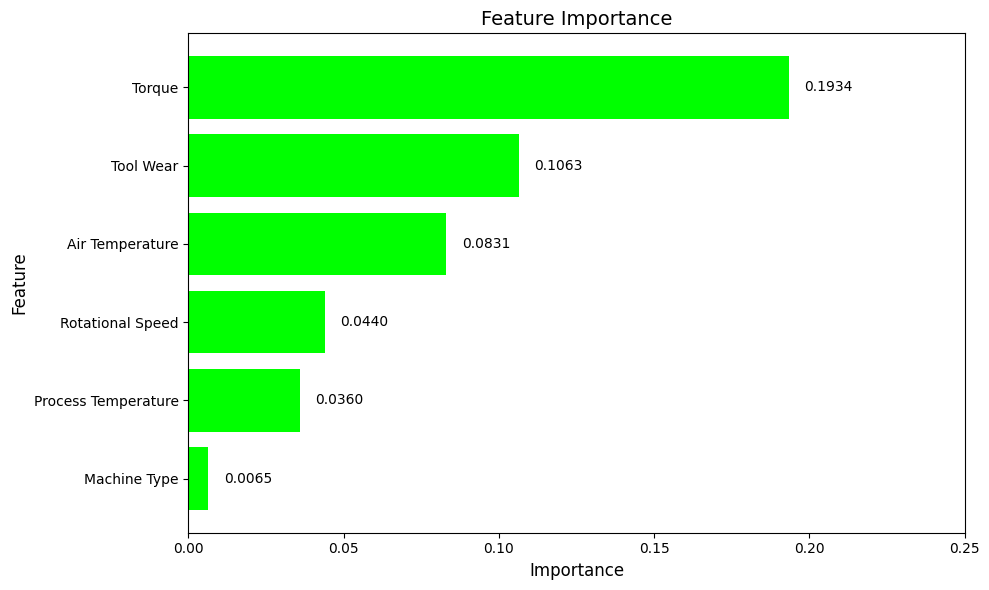

In [25]:
# Plot feature importance as a horizontal bar chart
plot_df = importance_df.sort_values(by = 'Importance', ascending = False)

# Create figure
plt.figure(figsize = (10, 6))

# Horizontal bar plot
bars = plt.barh(range(len(plot_df)), plot_df['Importance'], color = 'lime')

# Reverse the y-axis order to put highest at top
plt.gca().invert_yaxis()

# Y-ticks
plt.yticks(range(len(plot_df)), plot_df['Feature'])

# Choose axes labels
plt.xlabel('Importance', fontsize = 12)
plt.ylabel('Feature', fontsize = 12)

# Choose title
plt.title('Feature Importance', fontsize = 14)

# Set X-axis limit
plt.xlim(0, 0.25)

# Add feature importance values onto each bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', ha = 'left', va = 'center', fontsize = 10)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

##Distribution Plots

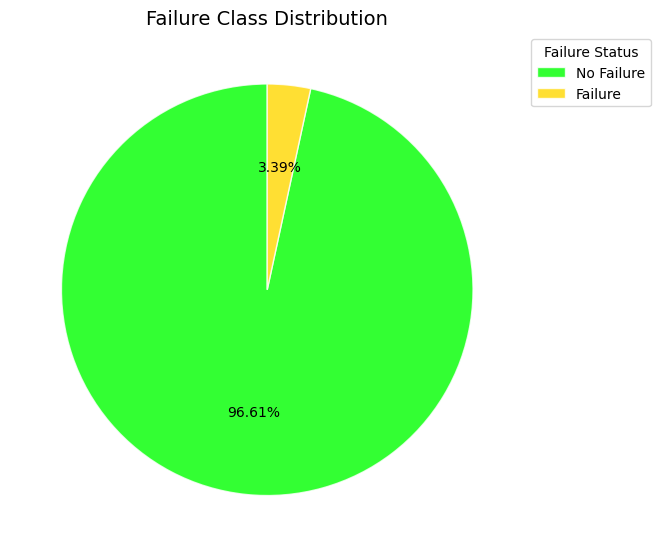

In [26]:
#  Failure Class Distribution Plot
def plot_class_distribution(data, fig, gs):
    """Plot class distribution pie chart"""

    # Create a subplot
    ax1 = fig.add_subplot(gs[0, 0])

    # Count occurrences of each class in 'Machine failure' column
    machine_failure_counts = data['Machine failure'].value_counts()

    # Choose colors and labels
    colors = ['lime', 'gold']
    labels = ['No Failure', 'Failure']

    # Generate the pie chart
    wedges, texts, autotexts = ax1.pie(machine_failure_counts.values,
                                       labels = None,
                                       autopct = '%.2f%%',
                                       colors = colors,
                                       startangle = 90,
                                       wedgeprops = {'linewidth': 1, 'edgecolor': 'white', 'alpha': 0.8})

    # Add legend
    ax1.legend(wedges, labels,
              title = "Failure Status",
              loc = "upper left",
              bbox_to_anchor = (1, 0, 0.5, 1))

    # Set the title
    ax1.set_title('Failure Class Distribution', fontsize = 14, fontweight = 'normal')

# Create figure
fig = plt.figure(figsize = (12, 6))
gs = gridspec.GridSpec(1, 2)

# Call the function
plot_class_distribution(data, fig, gs)

# Adjust layout
plt.tight_layout()

# Display plot
plt.show()

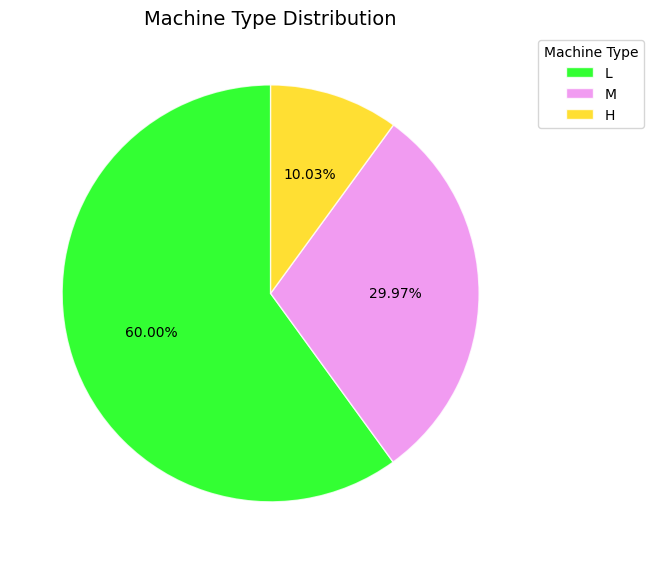

In [27]:
# Machine Type Distribution Plot
def plot_type_distribution(data, fig, gs):
    """Plot type distribution pie chart"""

    # Create a subplot
    ax1 = fig.add_subplot(gs[0, 0])

    # Count occurrences of each class in 'Type' column
    machine_type_counts = data['Type'].value_counts()

    # Choose colors and labels
    colors = ['lime', 'violet', 'gold']
    labels = ['L', 'M', 'H']

    # Pie chart
    wedges, texts, autotexts = ax1.pie(machine_type_counts.values,
                                       labels = None,
                                       autopct = '%.2f%%',
                                       colors = colors,
                                       startangle = 90,
                                       wedgeprops = {'linewidth': 1, 'edgecolor': 'white', 'alpha': 0.8})

    # Add legend
    ax1.legend(wedges, labels,
              title = "Machine Type",
              loc = "upper left",
              bbox_to_anchor = (1, 0, 0.5, 1))

    # Set the title
    ax1.set_title('Machine Type Distribution', fontsize = 14, fontweight = 'normal')

# Create figure
fig = plt.figure(figsize = (12, 6))
gs = gridspec.GridSpec(1, 2)

# Call the function
plot_type_distribution(data, fig, gs)

# # Adjust layout
plt.tight_layout()

# Display plot
plt.show()

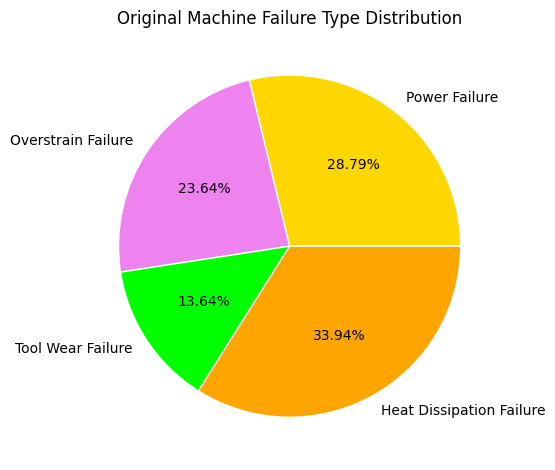

In [28]:
# Machine Failure Type distribution after pre-processing
# Calculate failure counts for machine failures
failure_counts = df1[df1['Machine_failure'] == 1]['Failure_type'].value_counts()

# Ensure consistent category order
categories = ['Power Failure', 'Overstrain Failure', 'Tool Wear Failure', 'Heat Dissipation Failure']

# Choose consistent color mapping
category_colors = {
    'Power Failure': 'gold',
    'Overstrain Failure': 'violet',
    'Tool Wear Failure': 'lime',
    'Heat Dissipation Failure': 'orange'
}

# Reorder counts according to predefined categories
failure_counts = [failure_counts.get(cat, 0) for cat in categories]

# Create pie chart with consistent category-color mapping
plt.pie(
    failure_counts,
    labels = categories,
    autopct = '%.2f%%',
    colors=[category_colors[cat] for cat in categories],
    wedgeprops = {'linewidth': 1, 'edgecolor': 'white'}
)

# Set title
plt.title('Original Machine Failure Type Distribution', fontweight = 'normal')

# Set layout
plt.tight_layout()

# Display plot
plt.show()


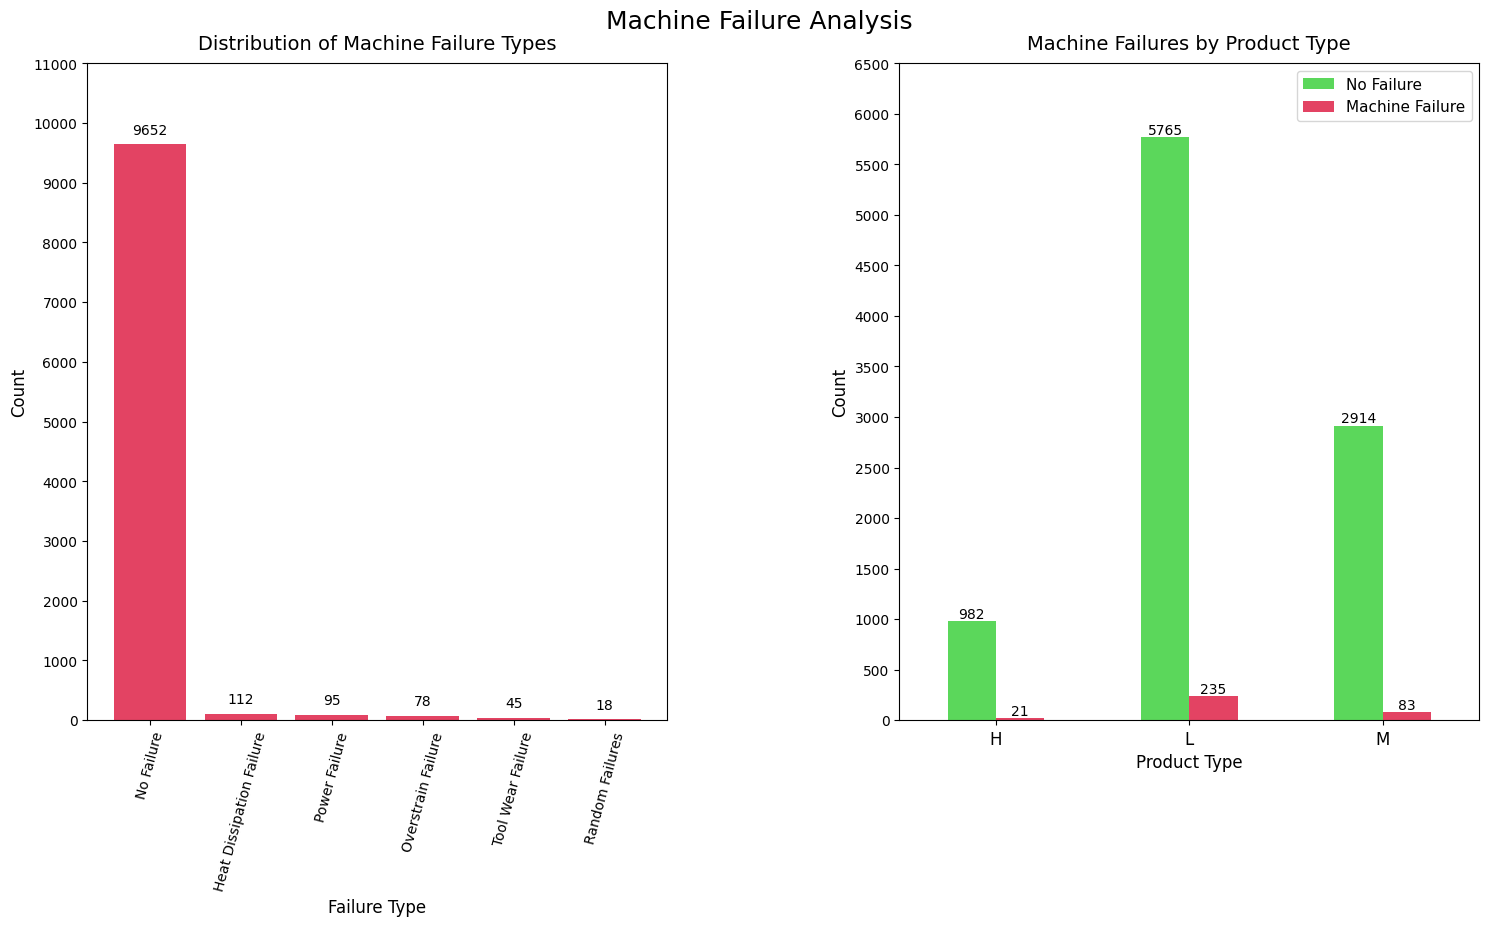

In [29]:
# Machine Failure Analysis

# Create figure
fig = plt.figure(figsize = (16, 9))

# Set title
fig.suptitle('Machine Failure Analysis', fontsize = 18, fontweight = 'normal', y = 0.94)

# Create gridspec layout for two plots side by side
gs = fig.add_gridspec(1, 2, hspace = 0.3, wspace = 0.4)

# Create subplot axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# 1. Distribution of Failure Types
# Count occurrences of each class in 'Failure Type' column
failure_counts = data['Failure Type'].value_counts()

# Create a bar plot
bars = ax1.bar(failure_counts.index, failure_counts.values, color = 'crimson', alpha = 0.8)

# Set title
ax1.set_title('Distribution of Machine Failure Types', fontsize = 14, pad = 10)

# Set labels
ax1.set_xlabel('Failure Type', fontsize = 12)
ax1.set_ylabel('Count', fontsize = 12)

# Set axes ticks
ax1.tick_params(axis = 'x', rotation = 75, labelsize = 10)
ax1.tick_params(axis = 'y', labelsize = 10)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{int(height)}', xy = (bar.get_x() + bar.get_width() / 2, height),
                xytext = (0, 5), textcoords = "offset points", ha = 'center', va = 'bottom',
                fontsize = 10, fontweight = 'normal')

# Set y-axis range and ticks for first plot
ax1.set_ylim(0, 10000)
ax1.set_yticks(range(0, 11001, 1000))

# 2. Machine Failures by Product Type
# Create a cross-tabulation contingency table to analyze the relationship between Type and Machine Failure
failure_by_type = pd.crosstab(data['Type'], data['Machine failure'])

# Create bar plot
bars2 = failure_by_type.plot(kind='bar', ax = ax2, color = ['limegreen', 'crimson'], alpha = 0.8)

# Set title
ax2.set_title('Machine Failures by Product Type', fontsize = 14, pad = 10)

# Set label
ax2.set_xlabel('Product Type', fontsize = 12)
ax2.set_ylabel('Count', fontsize = 12)

# Create legend
ax2.legend(['No Failure', 'Machine Failure'], fontsize = 11, frameon = True, fancybox = True, shadow = False)

# Set axes ticks
ax2.tick_params(axis = 'x', rotation = 0, labelsize = 12)
ax2.tick_params(axis = 'y', labelsize = 10)

# Add value labels on top of each bar
for container in ax2.containers:
    ax2.bar_label(container, fmt = '%d', label_type = 'edge', fontsize = 10, fontweight = 'normal')

# Set y-axis range and ticks
ax2.set_ylim(0, 6500)
ax2.set_yticks(range(0, 6501, 500))

# Set layout
plt.subplots_adjust(top = 0.88, bottom = 0.15, left = 0.08, right = 0.95, hspace = 0.2, wspace = 0.3)

# Display plot
plt.show()

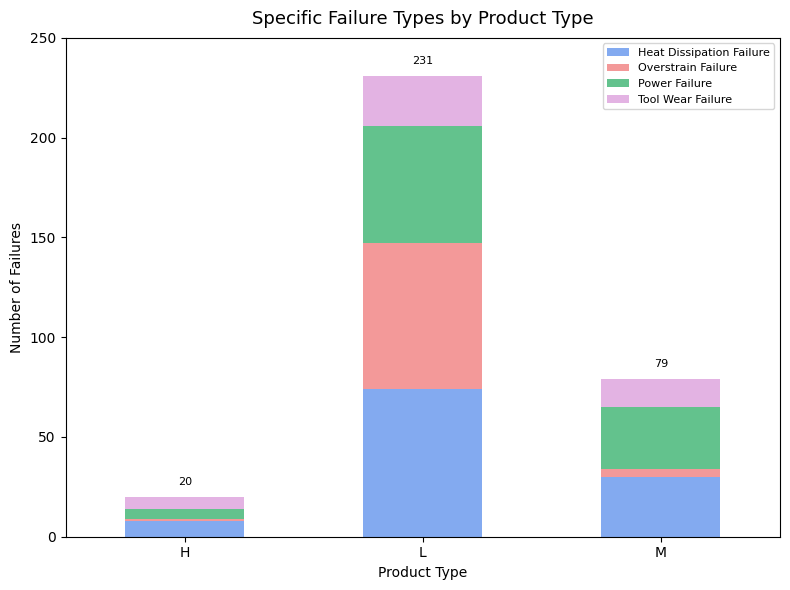

In [30]:
# Specific Failure Types by Product Type after pre-processing

# Create figure
fig, ax = plt.subplots(figsize = (8, 6))

# Filter out non-relevant failure types
specific_failures = df1[(df1['Failure_type'] != 'No Failure') &
                        (df1['Failure_type'] != 'Random Failures')]

# Create cross-tabulation of failures by product type
failure_product = pd.crosstab(specific_failures['Type'],
                             specific_failures['Failure_type'])

# Create stacked bar plot
failure_product.plot(kind = 'bar', stacked = True, ax = ax,
                    color = ['cornflowerblue', 'lightcoral', 'mediumseagreen', 'plum'],
                    alpha = 0.8)

# Set title
ax.set_title('Specific Failure Types by Product Type',
             fontsize = 13, fontweight = 'normal', pad = 10)

# Name labels
ax.set_xlabel('Product Type', fontsize = 10)
ax.set_ylabel('Number of Failures', fontsize = 10)

# Set axes limits and ticks
ax.set_ylim(0, 250)
ax.set_yticks(range(0, 251, 50))
ax.tick_params(axis = 'x', rotation = 0)

# Add legend
ax.legend(loc = 'upper right', fontsize = 8)

# Add total count labels on bars
for i, product_type in enumerate(failure_product.index):
    total = failure_product.loc[product_type].sum()
    ax.text(i, total + 5, f'{int(total)}',
            ha = 'center', va = 'bottom', fontsize = 8, fontweight = 'normal')

# Set layout
plt.tight_layout()

# Display plot
plt.show()

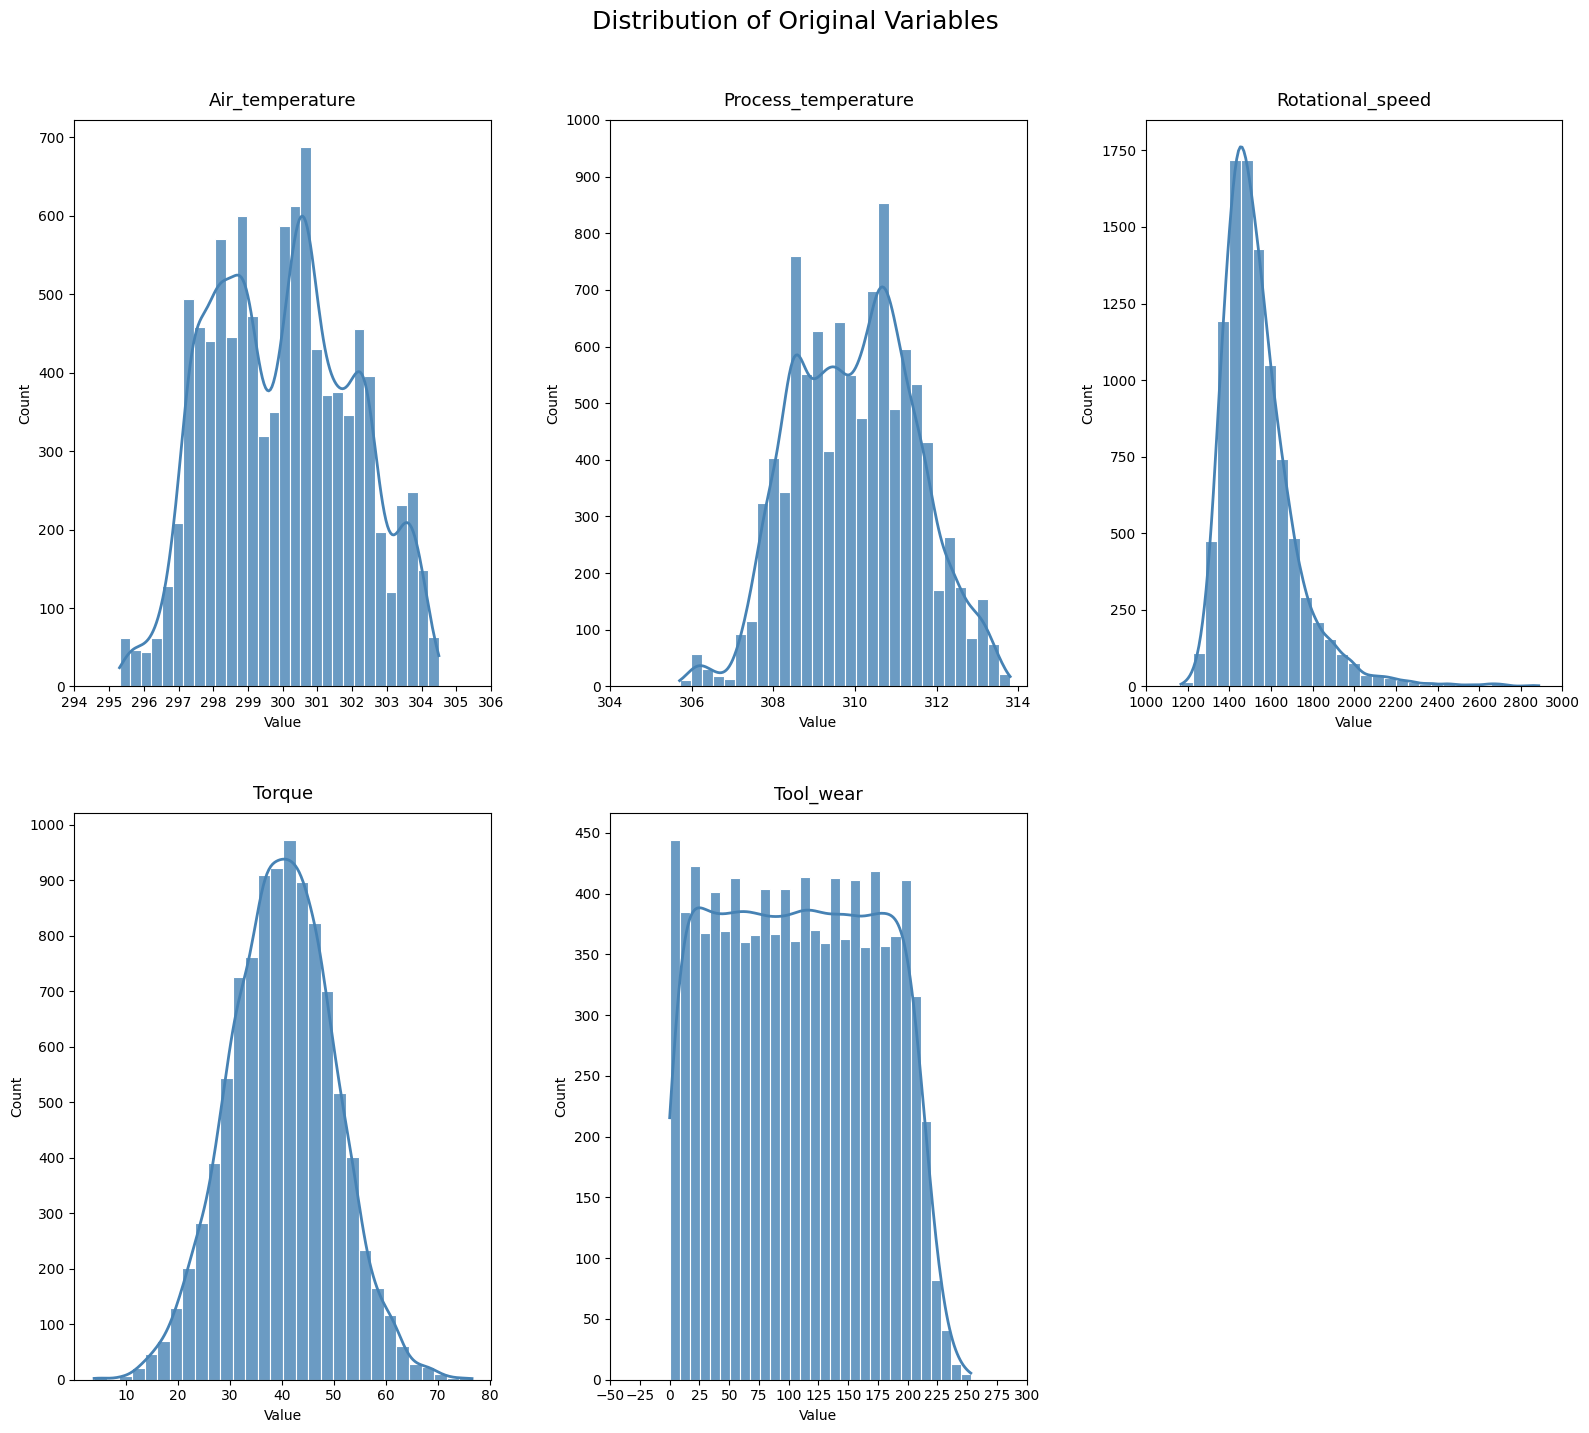

In [31]:
# Distribution of Original Variables

# Create figure
plt.figure(figsize = (16, 14))

# Set main title
plt.suptitle('Distribution of Original Variables', fontsize = 18, y = 1.02, fontweight = 'normal')

# Choose colors
hist_color = 'steelblue'
kde_color = 'red'

# Define the numerical features to plot
features = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']

# Loop through each feature to create distribution plots
for i, col in enumerate(features):

    # Create subplot for each feature
    ax = plt.subplot(2, 3, i + 1)

    # Plot histogram
    sns.histplot(df1[col], bins = 30, color = hist_color, edgecolor = 'white',
                 alpha = 0.8, kde = True, line_kws = {'color': kde_color, 'lw': 2})

    # Set title
    ax.set_title(col, fontsize = 13, pad = 10, fontweight = 'normal')

    # Set axes labels
    ax.set_xlabel('Value', fontsize = 10, fontweight = 'normal')
    ax.set_ylabel('Count', fontsize = 10, fontweight = 'normal')

    # Set custom axes ranges and tick spacing
    if col == 'Air_temperature':
        ax.set_xlim(294, 306)
        ax.set_xticks(range(294, 307, 1))
    elif col == 'Process_temperature':
        ax.set_xlim(left = 304)
        ax.set_ylim(top = 1000)
        ax.set_yticks(range(0, 1001, 100))
    elif col == 'Rotational_speed':
        ax.set_xlim(1000, 3000)
        ax.set_xticks(range(1000, 3001, 200))
    elif col == 'Torque':
        ax.set_xlim(left = 0)
        ax.set_xticks(range(10, 81, 10))
        ax.set_yticks(range(0, 1001, 100))
    elif col == 'Tool_wear':
        ax.set_xlim(left = -50)
        ax.set_xticks(range(-50, 301, 25))
        ax.set_yticks(range(0, 451, 50))

# Remove empty subplot
plt.delaxes(plt.subplot(2, 3, 6))

# Adjust layout
plt.tight_layout(h_pad = 4.0, w_pad = 3.0)

# Display plot
plt.show()

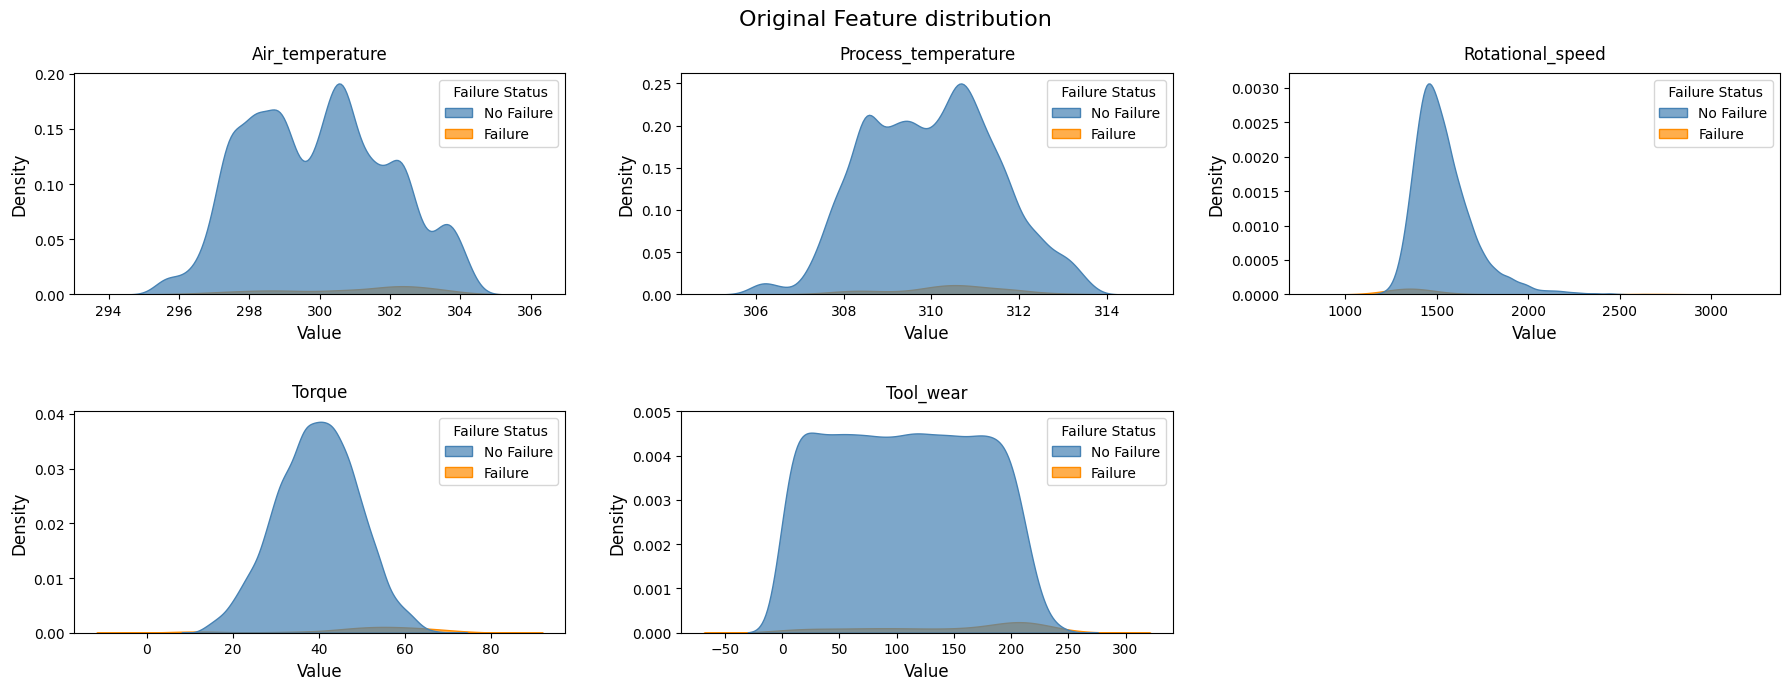

In [32]:
# Original Feature Distribution

# Define numerical features
numerical_features = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']

# Create subplot grid layout
figure, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 7))

# Create main title
figure.suptitle('Original Feature distribution', fontsize = 16, fontweight = 'normal')

# Generate KDE plots for each numerical feature
for index, feature_name in enumerate(numerical_features):
    # Calculate row and column positions for subplot grid
    row_position = index // 3
    col_position = index % 3

    # Create KDE plot for machine failure classes
    sns.kdeplot(ax = axes[row_position, col_position],
                data = df1,
                x = feature_name,
                hue = 'Machine_failure',
                fill = True,
                palette = ['steelblue', 'darkorange'],
                alpha = 0.7)

    # Map legend labels for machine failure status
    current_legend = axes[row_position, col_position].get_legend()
    if current_legend:
        current_legend.set_title(' Failure Status')
        legend_labels = current_legend.get_texts()
        if len(legend_labels) >= 2:
            legend_labels[0].set_text('No Failure')
            legend_labels[1].set_text('Failure')

    # Set axes labels
    axes[row_position, col_position].set_xlabel('Value', fontsize = 12, fontweight = 'normal')
    axes[row_position, col_position].set_ylabel('Density', fontsize = 12, fontweight = 'normal')
    axes[row_position, col_position].set_title(f'{feature_name}', fontsize = 12, fontweight = 'normal', pad = 10)

    # Set custom y-tick spacing
    if feature_name == 'Tool_wear':
       y_max = 0.005
       axes[row_position, col_position].set_ylim(0, y_max)
       axes[row_position, col_position].set_yticks(np.linspace(0, y_max, 6))
       axes[row_position, col_position].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))

# Remove empty subplot
figure.delaxes(axes[1, 2])

# Adjust layout
plt.tight_layout(h_pad = 3.0, w_pad = 2.5)

# Display plot
plt.show()

##Correlation Analysis


Feature correlations with Machine failure:
Failure_type           0.904
Torque                 0.193
Tool_wear              0.106
Air_temperature        0.083
Process_temperature    0.036
Type_encoded          -0.006
Rotational_speed      -0.044


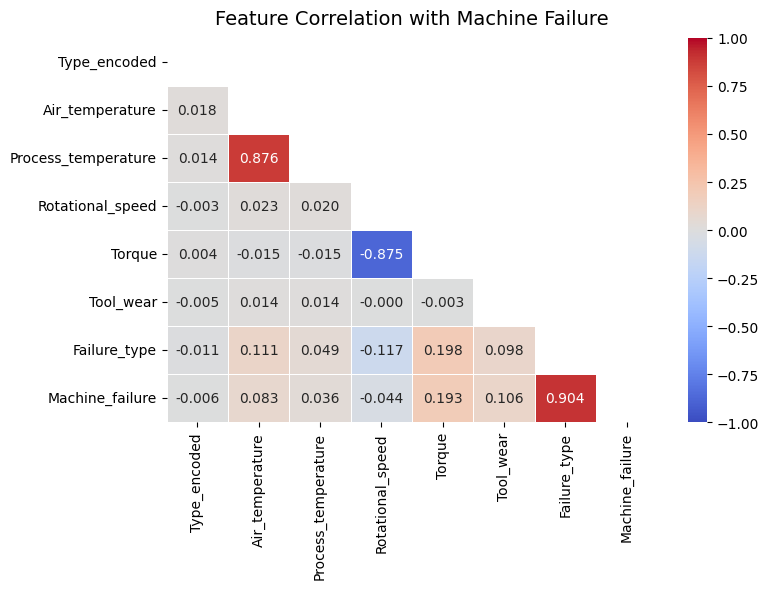

In [33]:
# Correlation Analysis

# Convert categorical Failure_type to numeric codes
df1['Failure_type'] = pd.factorize(df1['Failure_type'])[0]

# Analysis with numerical features
numerical_features = ['Type_encoded', 'Air_temperature', 'Process_temperature',
                     'Rotational_speed', 'Torque', 'Tool_wear', 'Failure_type']

# Compute Pearson correlation matrix
corr_matrix = df1[numerical_features + ['Machine_failure']].corr()

# Create figure
plt.figure(figsize = (8, 6))

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

# Heatmap
sns.heatmap(corr_matrix, mask = mask, annot = True, fmt = ".3f", cmap = 'coolwarm',
            vmin = -1, vmax = 1, linewidths = 0.5, linecolor = 'white')

# Set title
plt.title('Feature Correlation with Machine Failure', fontsize = 14, fontweight = 'normal', pad = 10)

# Set layout
plt.tight_layout()

# Correlation results output
print("\nFeature correlations with Machine failure:")
print(corr_matrix['Machine_failure'].sort_values(ascending = False).drop('Machine_failure').to_string(float_format = "%.3f"))

# Display plot
plt.show()

##Outlier Inspection

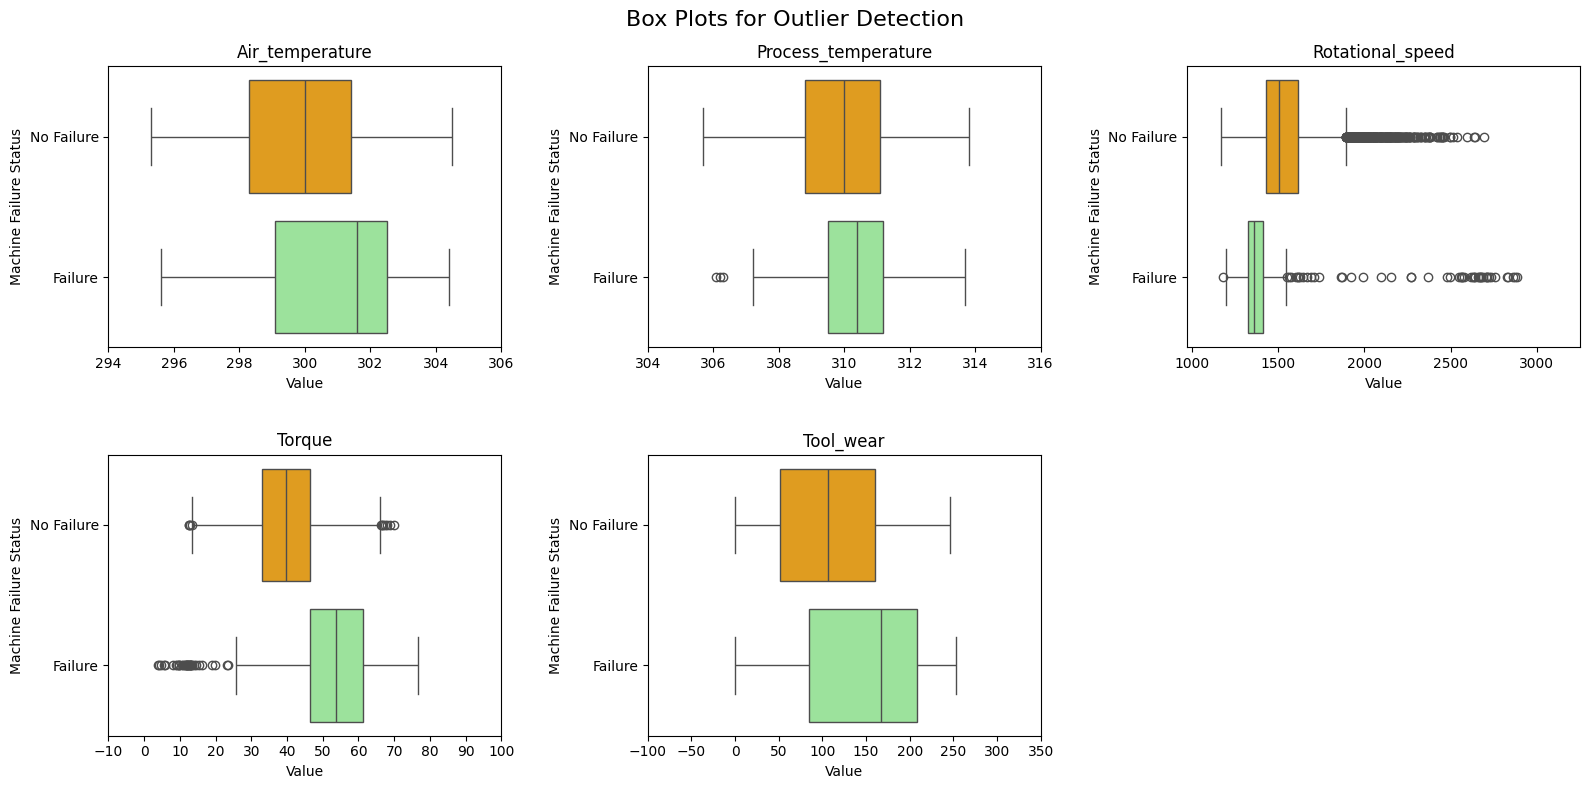

In [34]:
# Define numerical features for analysis
features = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']

# Define custom x-axis ranges for each feature
x_ranges = {
    'Air_temperature': (294, 306),
    'Process_temperature': (304, 316),
    'Rotational_speed': (974, 3250),
    'Torque': (-10, 100),
    'Tool_wear': (-100, 350)
}

# Create box plots for outlier inspection
plt.figure(figsize = (16, 8))

# Set main title
plt.suptitle('Box Plots for Outlier Detection', fontsize = 16, fontweight = 'normal')

# Generate box plots for each feature
for i, feature in enumerate(features):
    # Create subplot grid (2 rows, 3 columns)
    plt.subplot(2, 3, i + 1)

    # Create horizontal box plot
    sns.boxplot(data = df1, y = 'Machine_failure', x = feature, hue = 'Machine_failure',
                palette = ['orange', 'lightgreen'], legend = False, orient = 'h')

    # Set subplot titles
    plt.title(f'{feature}', fontsize = 12, fontweight = 'normal')

    # Set axes labels
    plt.xlabel('Value', fontsize = 10, fontweight = 'normal')
    plt.ylabel('Machine Failure Status', fontsize = 10, fontweight = 'normal')

    # Map Y-axis labels
    plt.yticks([0, 1], ['No Failure', 'Failure'], fontweight = 'normal')

    # Set custom x-axis range for each feature
    plt.xlim(x_ranges[feature])

    # Choose axis ticks to include range boundaries for Torque
    if feature == 'Torque':
        plt.xticks(range(-10, 101, 10))

# Remove empty subplot
plt.delaxes(plt.subplot(2, 3, 6))

# Adjust layout
plt.tight_layout(h_pad = 3.0, w_pad = 2.5)

# Display the plot
plt.show()

##Feature Scaling

In [35]:
# Scale numerical features

# Initialize StandardScaler to normalize numerical features (mean=0, std=1)
scaler = StandardScaler()

# List of numerical columns to be scaled
numerical_cols = ['Air_temperature', 'Process_temperature', 'Rotational_speed','Torque', 'Tool_wear']

# Create a copy of the original DataFrame
df1_scaled = df1.copy()

# Apply scaling to the selected numerical columns
df1_scaled[numerical_cols] = scaler.fit_transform(df1[numerical_cols])

# Display first 5 rows of scaled DataFrame
df1_scaled.head()

,UID,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Failure_type,Product_ID_clean,Type_encoded
0,1,M14860,M,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0,0,0,0,0,0,0,14860,2
1,2,L47181,L,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0,0,0,0,0,0,0,47181,1
2,3,L47182,L,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0,0,0,0,0,0,0,47182,1
3,4,L47183,L,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0,0,0,0,0,0,0,47183,1
4,5,L47184,L,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0,0,0,0,0,0,0,47184,1


In [36]:
# Print all column names
print("\nAll columns in data:")
print(df.columns.tolist())

print("\nAll columns in df1:")
print(df1_scaled.columns.tolist())

print("\nAll columns in df4_scaled:")
print(df1_scaled.columns.tolist())

# Print shape
print(f"\nOriginal shape: {data.shape}")
print(f"Feature Engineered shape: {df1_scaled.shape}")
print(f"Scaled df1 shape: {df1_scaled.shape}")


All columns in data:
['UID', 'Product_ID', 'Type', 'Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Failure_type', 'Product_ID_clean']

All columns in df1:
['UID', 'Product_ID', 'Type', 'Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Failure_type', 'Product_ID_clean', 'Type_encoded']

All columns in df4_scaled:
['UID', 'Product_ID', 'Type', 'Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Failure_type', 'Product_ID_clean', 'Type_encoded']

Original shape: (10000, 15)
Feature Engineered shape: (9973, 17)
Scaled df1 shape: (9973, 17)


##Statistical Significant Tests

In [37]:
# Initialize results list
results = []

# Chi-square tests (Type vs flags)
for flag in ['TWF', 'HDF', 'PWF', 'OSF']:
    chi2, p = chi2_contingency(pd.crosstab(df1_scaled['Type_encoded'], df1_scaled[flag]))[:2]
    results.append({
        'Important Feature': flag,
        'Result': 'Significant association' if p < 0.05 else 'No association',
        'Test Type': 'Chi-square',
        'Test Statistic': f"{chi2:.3f}",
        'p-value': f"{p:.4f}"
    })

# T-tests (Numerical features vs failure)
for num_var in ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']:
    t_stat, p = ttest_ind(
        df1_scaled[df1_scaled['Machine_failure'] == 1][num_var],
        df1_scaled[df1_scaled['Machine_failure'] == 0][num_var],
        equal_var = False
    )
    results.append({
        'Important Feature': num_var,
        'Result': 'Significant difference' if p < 0.05 else 'No difference',
        'Test Type': 'T-test',
        'Test Statistic': f"{t_stat:.3f}",
        'p-value': f"{p:.4f}"
    })

# Create styled DataFrame
styled_df = (
    pd.DataFrame(results)
    .style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
)

# Display table
display(styled_df)

Important Feature,Result,Test Type,Test Statistic,p-value
TWF,No association,Chi-square,1.503,0.4717
HDF,No association,Chi-square,2.157,0.3401
PWF,No association,Chi-square,2.451,0.2937
OSF,Significant association,Chi-square,34.220,0.0000
Air_temperature,Significant difference,T-test,8.015,0.0000
Process_temperature,Significant difference,T-test,3.884,0.0001
Rotational_speed,Significant difference,T-test,-2.053,0.0408
Torque,Significant difference,T-test,11.829,0.0000
Tool_wear,Significant difference,T-test,9.306,0.0000


##Data Preparation

In [38]:
# Select features for modeling
feature_columns = ['Air_temperature', 'Process_temperature', 'Rotational_speed',
                   'Torque', 'Tool_wear', 'Type_encoded']

# Create unscaled data from df1
X_unscaled = df1[feature_columns]
y = df1['Machine_failure']

# Split the unscaled data
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
    X_unscaled, y, test_size = 0.2, random_state = 17, stratify = y
)

# Create scaled data for MLP and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unscaled)
X_test_scaled = scaler.transform(X_test_unscaled)

# Print the sizes and distribution
print("Data Split Information:")
print(f"Training set size: {X_train_unscaled.shape}")
print(f"Test set size: {X_test_unscaled.shape}")
print(f"Training set failure rate: {y_train.mean():.4f}")
print(f"Test set failure rate: {y_test.mean():.4f}")
print(f"\nData types:")
print(f"Unscaled data type: {type(X_train_unscaled)}")
print(f"Scaled data type: {type(X_train_scaled)}")

Data Split Information:
Training set size: (7978, 6)
Test set size: (1995, 6)
Training set failure rate: 0.0331
Test set failure rate: 0.0331

Data types:
Unscaled data type: <class 'pandas.core.frame.DataFrame'>
Scaled data type: <class 'numpy.ndarray'>


##Baseline Model Training

In [39]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state = 17),
    'MLP Classifier': MLPClassifier(
        hidden_layer_sizes = (128, 64, 32),
        max_iter = 200,
        learning_rate_init = 0.001,
        random_state = 17,
        early_stopping = True,
        validation_fraction = 0.1,
        n_iter_no_change = 5,
        verbose = False
    ),
    'KNN': KNeighborsClassifier()
}

# Initialize storage for baseline results
baseline_results = {}
baseline_probabilities = {}
baseline_predictions = {}
baseline_training_history = {}
mlp_epoch_details = []

# Train each model with appropriate data
print("TRAINING BASELINE MODELS (Without Oversampling):")
print("-"*80)

for name, model in models.items():
    print(f"\nTraining {name}:")

    # Select appropriate data based on model type
    if name == 'Random Forest':
        X_train_use = X_train_unscaled
        X_test_use = X_test_unscaled
        print("  Using: Unscaled data (DataFrame)")
    else:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
        print("  Using: Scaled data (NumPy array)")

    # Train model on data
    start_time = time.time()

    if name == 'MLP Classifier':

        # Split for validation
        X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = tts(
            X_train_use, y_train, test_size = 0.1, random_state = 17, stratify = y_train
        )

        # Train epoch by epoch
        model.set_params(warm_start = True, max_iter = 1)
        best_val_score = -np.inf
        no_improvement_count = 0

        for epoch in range(1, 201):
            model.fit(X_train_mlp, y_train_mlp)

            # Calculate metrics
            train_pred = model.predict(X_train_mlp)
            train_proba = model.predict_proba(X_train_mlp)[:, 1]
            val_pred = model.predict(X_val_mlp)
            val_proba = model.predict_proba(X_val_mlp)[:, 1]

            train_loss = log_loss(y_train_mlp, train_proba)
            val_loss = log_loss(y_val_mlp, val_proba)
            train_f1 = f1_score(y_train_mlp, train_pred, zero_division = 0)
            train_recall = recall_score(y_train_mlp, train_pred, zero_division = 0)
            val_f1 = f1_score(y_val_mlp, val_pred, zero_division = 0)
            val_recall = recall_score(y_val_mlp, val_pred, zero_division = 0)

            # Print epoch results
            print(f"  Epoch {epoch} - loss: {train_loss:.4f} - f1_score: {train_f1:.4f} - "
                  f"recall: {train_recall:.4f} - val_loss: {val_loss:.4f} - "
                  f"val_f1_score: {val_f1:.4f} - val_recall: {val_recall:.4f} - "
                  f"learning_rate: {model.learning_rate_init:.4f}")

            # Store epoch data
            mlp_epoch_details.append({
                'Epoch': epoch,
                'Learning_Rate': model.learning_rate_init,
                'Loss': train_loss,
                'F1_Score': train_f1,
                'Recall': train_recall,
                'Val_Loss': val_loss,
                'Val_F1_Score': val_f1,
                'Val_Recall': val_recall
            })

            # Early stopping check
            val_score = val_f1
            if val_score > best_val_score + 0.0001:
                best_val_score = val_score
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= 5:
                print(f"  Validation score did not improve for 5 consecutive epochs. Stopping.")
                break

        # Store final iteration count
        baseline_training_history[name] = {
            'n_iter': epoch,
            'epoch_details': mlp_epoch_details.copy()
        }

    else:
        # For Random Forest and KNN
        model.fit(X_train_use, y_train)

    # Training time calculation
    training_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test_use)
    y_proba = model.predict_proba(X_test_use)[:, 1]

    # Calculate loss
    loss = log_loss(y_test, y_proba)

    # Store results
    baseline_predictions[name] = y_pred
    baseline_probabilities[name] = y_proba

    # Calculate performance metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division = 0),
        'Recall': recall_score(y_test, y_pred, zero_division = 0),
        'F1-Score': f1_score(y_test, y_pred, zero_division = 0),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Loss': loss
    }

    # Store performance metrics
    baseline_results[name] = metrics

    # Print results for RF and KNN
    if name in ['Random Forest', 'KNN']:
        print(f"  Result - "
              f"loss: {loss:.4f} - f1_score: {metrics['F1-Score']:.4f} - recall: {metrics['Recall']:.4f} - "
              f"val_loss: {loss:.4f} - val_f1_score: {metrics['F1-Score']:.4f} - val_recall: {metrics['Recall']:.4f} - "
              f"learning_rate: 0.0000e+00")

TRAINING BASELINE MODELS (Without Oversampling):
--------------------------------------------------------------------------------

Training Random Forest:
  Using: Unscaled data (DataFrame)
  Result - loss: 0.0777 - f1_score: 0.7143 - recall: 0.6061 - val_loss: 0.0777 - val_f1_score: 0.7143 - val_recall: 0.6061 - learning_rate: 0.0000e+00

Training MLP Classifier:
  Using: Scaled data (NumPy array)
  Epoch 1 - loss: 0.1597 - f1_score: 0.0000 - recall: 0.0000 - val_loss: 0.1672 - val_f1_score: 0.0000 - val_recall: 0.0000 - learning_rate: 0.0010
  Epoch 2 - loss: 0.1186 - f1_score: 0.0000 - recall: 0.0000 - val_loss: 0.1179 - val_f1_score: 0.0000 - val_recall: 0.0000 - learning_rate: 0.0010
  Epoch 3 - loss: 0.0963 - f1_score: 0.0726 - recall: 0.0378 - val_loss: 0.0859 - val_f1_score: 0.2667 - val_recall: 0.1538 - learning_rate: 0.0010
  Epoch 4 - loss: 0.0886 - f1_score: 0.4098 - recall: 0.2815 - val_loss: 0.0762 - val_f1_score: 0.5405 - val_recall: 0.3846 - learning_rate: 0.0010
  Epoc

##Baseline Analysis

In [40]:
# Performance Summary Table

# Create DataFrame for baseline results
baseline_df = pd.DataFrame(baseline_results).T.round(4)

# Style the table
styled_baseline_table = (
    baseline_df.style
    .hide(axis = "index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}',
        'ROC-AUC': '{:.4f}',
        'Loss': '{:.4f}'
    })
    # Add title
    .set_caption("Baseline Model Performance Metrics")
)

# Display the table
display(styled_baseline_table)

Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Loss
Random Forest,0.9840,0.8696,0.6061,0.7143,0.9725,0.0777
MLP Classifier,0.9784,0.7091,0.5909,0.6446,0.9793,0.0574
KNN,0.9749,0.8333,0.3030,0.4444,0.8659,0.3240


In [41]:
# Epochwise Performance Matrix - MLP Classifier
if mlp_epoch_details:

    # Display all epochs
    total_epochs = len(mlp_epoch_details)
    indices = range(total_epochs)

    # Get epoch data for display
    epoch_display_data = [mlp_epoch_details[i] for i in indices]

    # Create DataFrame from epoch details
    epoch_df = pd.DataFrame(epoch_display_data)

    # Style and format the DataFrame
    styled_epoch_table = (
        epoch_df.style
        .hide(axis = "index")
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th, td', 'props': 'border: 1px solid black;'},
            {'selector': 'th', 'props': 'background-color: lightgray;'}
        ])
        .format({
            'Epoch': '{:d}',
            'Learning_Rate': '{:.4f}',
            'Loss': '{:.4f}',
            'F1_Score': '{:.4f}',
            'Recall': '{:.4f}',
            'Val_Loss': '{:.4f}',
            'Val_F1_Score': '{:.4f}',
            'Val_Recall': '{:.4f}'
        })
        # Add title
        .set_caption("MLP Classifier Training Progress (All Epochs)")
    )

    # Display the table
    display(styled_epoch_table)

Epoch,Learning_Rate,Loss,F1_Score,Recall,Val_Loss,Val_F1_Score,Val_Recall
1,0.0010,0.1597,0.0000,0.0000,0.1672,0.0000,0.0000
2,0.0010,0.1186,0.0000,0.0000,0.1179,0.0000,0.0000
3,0.0010,0.0963,0.0726,0.0378,0.0859,0.2667,0.1538
4,0.0010,0.0886,0.4098,0.2815,0.0762,0.5405,0.3846
5,0.0010,0.0843,0.4689,0.3487,0.0723,0.6000,0.4615
6,0.0010,0.0807,0.4780,0.3655,0.0690,0.5854,0.4615
7,0.0010,0.0776,0.5213,0.4118,0.0662,0.6047,0.5000
8,0.0010,0.0746,0.5185,0.4118,0.0641,0.6667,0.5769
9,0.0010,0.0714,0.5445,0.4370,0.0609,0.6667,0.5769
10,0.0010,0.0685,0.5617,0.4496,0.0579,0.6957,0.6154


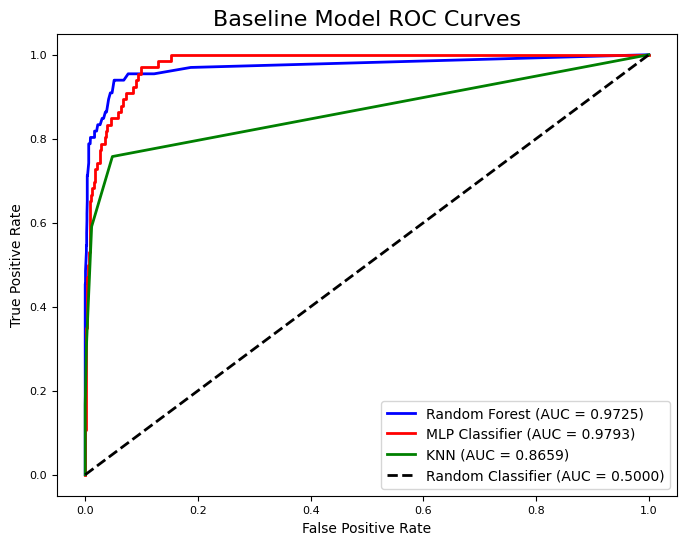

In [42]:
# ROC Curves for Baseline

# Create figure
plt.figure(figsize = (8, 6))

# Add title
plt.title('Baseline Model ROC Curves', fontsize = 16, fontweight = 'normal')

# Choose colors
colors = ['blue', 'red', 'green']

# Plot ROC curve for each baseline model
for idx, (name, y_proba) in enumerate(baseline_probabilities.items()):
    # Calculate FPR, TPR, and AUC for the current model
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve with a unique color and label including AUC
    plt.plot(fpr, tpr, color = colors[idx], lw = 2,
             label = f'{name} (AUC = {roc_auc:.4f})')

# Plot the diagonal line representing random classifier performance
plt.plot([0, 1], [0, 1], 'k--', lw = 2, label = 'Random Classifier (AUC = 0.5000)')

# Add axes labels
plt.xlabel('False Positive Rate', fontsize = 10)
plt.ylabel('True Positive Rate', fontsize = 10)

# Set axes ticks
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

# Add legend
plt.legend(loc = 'lower right')

# Grid
plt.grid(False)

# Display the plot
plt.show()

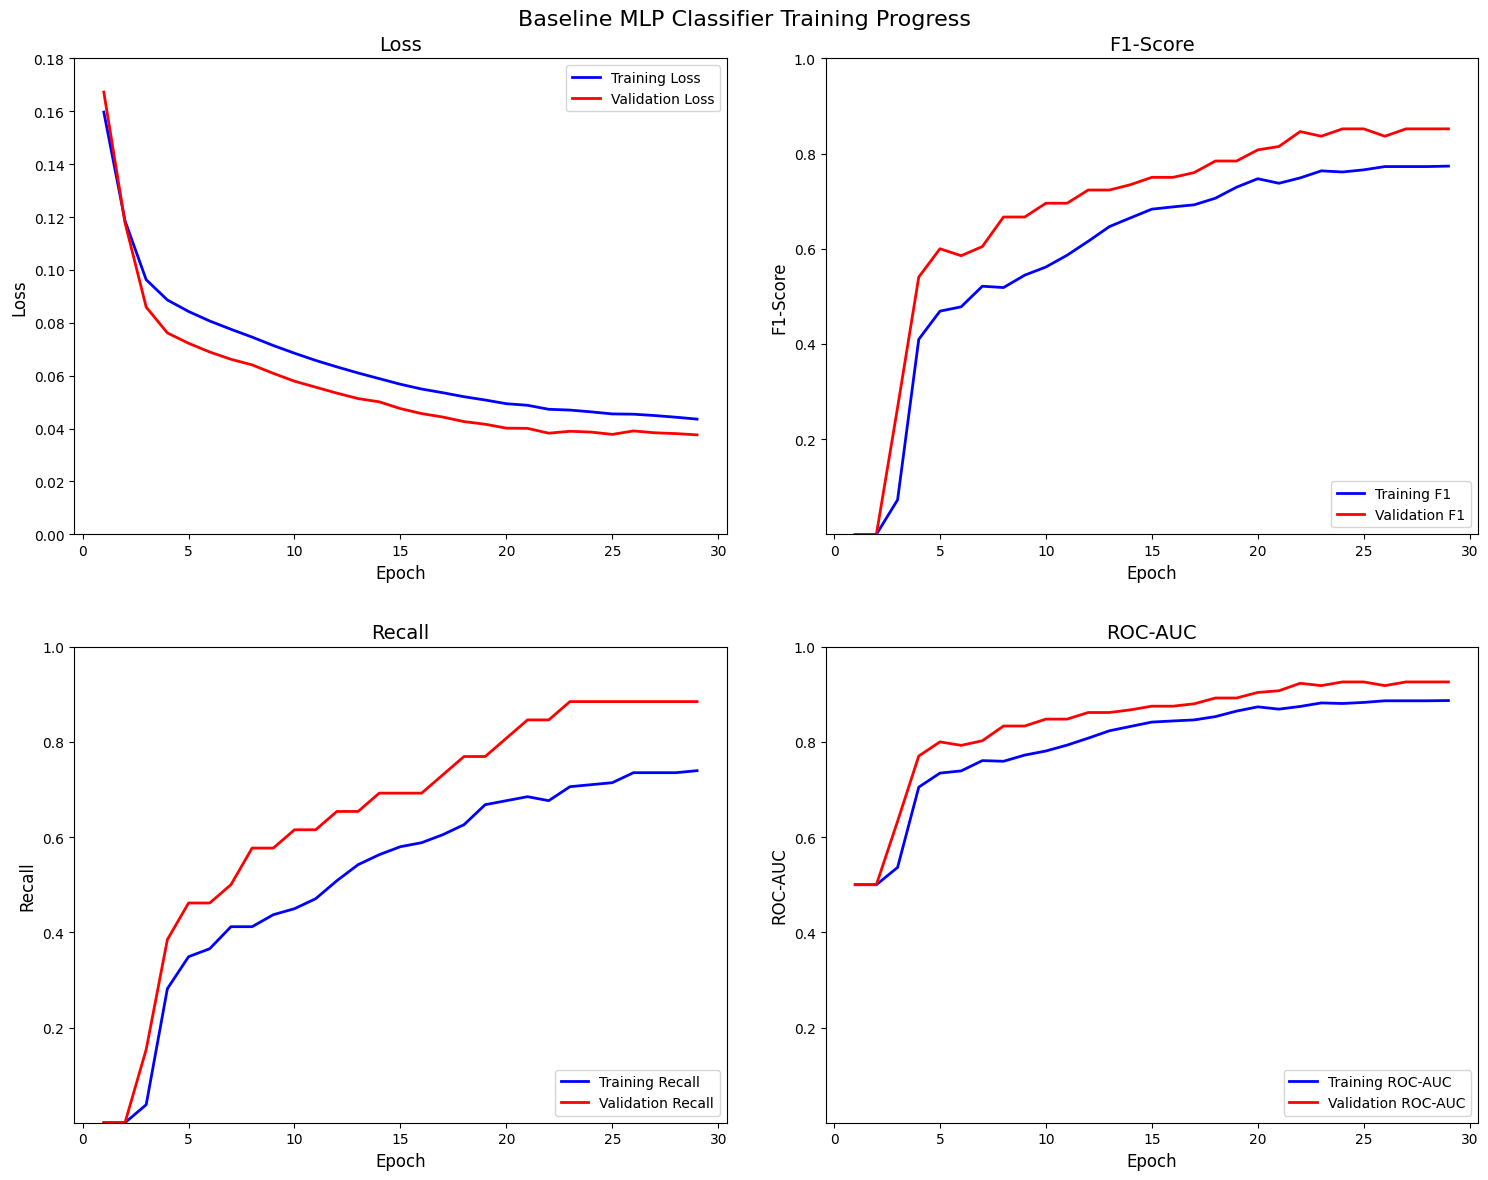

In [43]:
# Training/Validation Plot for MLP Classifier

# Training history data availability check
if mlp_epoch_details:
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 12))
    # Add main title
    fig.suptitle('Baseline MLP Classifier Training Progress', fontsize = 16, fontweight = 'normal')

    # Extract data from epoch details
    epochs = [d['Epoch'] for d in mlp_epoch_details]
    train_loss = [d['Loss'] for d in mlp_epoch_details]
    val_loss = [d['Val_Loss'] for d in mlp_epoch_details]
    train_f1 = [d['F1_Score'] for d in mlp_epoch_details]
    val_f1 = [d['Val_F1_Score'] for d in mlp_epoch_details]
    train_recall = [d['Recall'] for d in mlp_epoch_details]
    val_recall = [d['Val_Recall'] for d in mlp_epoch_details]

    # Calculate ROC-AUC progression (approximate from F1 and Recall)
    train_roc = [0.5 + 0.5 * f1 for f1 in train_f1]
    val_roc = [0.5 + 0.5 * f1 for f1 in val_f1]

    # Plot Loss
    ax1.plot(epochs, train_loss, 'b-', label = 'Training Loss', linewidth = 2)
    ax1.plot(epochs, val_loss, 'r-', label = 'Validation Loss', linewidth = 2)

    # Add title
    ax1.set_title('Loss', fontsize = 14, fontweight = 'normal')

    # Set axes labels
    ax1.set_xlabel('Epoch', fontsize = 12)
    ax1.set_ylabel('Loss', fontsize = 12)

    # Set y-axis ticks for loss plot
    ax1.set_yticks(np.arange(0, 0.19, 0.02))

    # Add legend
    ax1.legend()

    # Grid
    ax1.grid(False)

    # Plot F1-Score
    ax2.plot(epochs, train_f1, 'b-', label = 'Training F1', linewidth = 2)
    ax2.plot(epochs, val_f1, 'r-', label = 'Validation F1', linewidth = 2)

    # Add title
    ax2.set_title('F1-Score', fontsize = 14, fontweight = 'normal')

    # Set axes labels
    ax2.set_xlabel('Epoch', fontsize = 12)
    ax2.set_ylabel('F1-Score', fontsize = 12)

    # Set Y-axis limit
    ax2.set_ylim(0, 1)

    # Set y-axis ticks for F1-Score plot
    ax2.set_yticks(np.arange(0.2, 1.1, 0.2))

    # Add legend
    ax2.legend(loc = 'lower right')

    # Gird
    ax2.grid(False)

    # Plot Recall
    ax3.plot(epochs, train_recall, 'b-', label = 'Training Recall', linewidth = 2)
    ax3.plot(epochs, val_recall, 'r-', label = 'Validation Recall', linewidth = 2)

    # Add title
    ax3.set_title('Recall', fontsize = 14, fontweight = 'normal')

    # Set axes labels
    ax3.set_xlabel('Epoch', fontsize = 12)
    ax3.set_ylabel('Recall', fontsize = 12)

    #Set Y-axis limit
    ax3.set_ylim(0, 1)

    # Set y-axis ticks for Recall plot
    ax3.set_yticks(np.arange(0.2, 1.1, 0.2))

    # Add legend
    ax3.legend(loc = 'lower right')

    # Grid
    ax3.grid(False)

    # Plot ROC-AUC
    ax4.plot(epochs, train_roc, 'b-', label = 'Training ROC-AUC', linewidth = 2)
    ax4.plot(epochs, val_roc, 'r-', label = 'Validation ROC-AUC', linewidth = 2)

    # Add title
    ax4.set_title('ROC-AUC', fontsize = 14, fontweight = 'normal')

    # Set axes labels
    ax4.set_xlabel('Epoch', fontsize = 12)
    ax4.set_ylabel('ROC-AUC', fontsize = 12)

    # Set Y-axis limit
    ax4.set_ylim(0, 1)

    # Set y-axis ticks for ROC-AUC plot
    ax4.set_yticks(np.arange(0.2, 1.1, 0.2))

    # Add legend
    ax4.legend(loc = 'lower right')

    # Grid
    ax4.grid(False)

    # Adjust layout with increased padding between subplots
    plt.tight_layout(h_pad = 3.0, w_pad = 3.0)

    # Display the plot
    plt.show()

## Oversampling

In [44]:
# Apply oversampling techniques
print("APPLYING OVERSAMPLING TECHNIQUES:")

# Initialize oversampling techniques
techniques = {
    'SMOTE': SMOTE(random_state = 17),
    'ADASYN': ADASYN(random_state = 17),
    'RandomOverSampler': RandomOverSampler(random_state = 17),
    'SMOTETomek': SMOTETomek(random_state = 17)
}

# Apply each technique and store results
resampled_datasets = {}
oversampling_summary = []

# Store original class distribution
original_counts = y_train.value_counts().sort_index()
original_total = len(y_train)
original_failure_count = original_counts[1]
original_failure_rate = original_failure_count / original_total

# Add baseline (original) data to summary
oversampling_summary.append({
    'Technique': 'Baseline',
    'Original_Samples': original_total,
    'Resampled_Samples': original_total,
    'Failure_Count': original_failure_count,
    'Failure_Rate': original_failure_rate
})

# Apply each oversampling technique
for name, technique in techniques.items():
    # 1. Resample scaled data for MLP and KNN
    X_resampled_scaled, y_resampled_scaled = technique.fit_resample(X_train_scaled, y_train)

    # 2. Resample unscaled data for Random Forest
    # Create new instance of technique for unscaled data
    if name == 'SMOTE':
        technique_unscaled = SMOTE(random_state = 17)
    elif name == 'ADASYN':
        technique_unscaled = ADASYN(random_state = 17)
    elif name == 'RandomOverSampler':
        technique_unscaled = RandomOverSampler(random_state = 17)
    else:
        technique_unscaled = SMOTETomek(random_state = 17)

    # Apply resampling to unscaled data
    X_resampled_unscaled, y_resampled_unscaled = technique_unscaled.fit_resample(X_train_unscaled, y_train)

    # Store both scaled and unscaled versions
    resampled_datasets[name] = {
        'scaled': (X_resampled_scaled, y_resampled_scaled),
        'unscaled': (X_resampled_unscaled, y_resampled_unscaled)
    }

    # Print class distribution after resampling
    counts = pd.Series(y_resampled_scaled).value_counts().sort_index()
    print(f"{name} - No Failure: {counts[0]}, Failure: {counts[1]}")

    # Calculate statistics for summary
    resampled_total = len(y_resampled_scaled)
    failure_count = counts[1]
    failure_rate = failure_count / resampled_total

    # Add resampling results to summary
    oversampling_summary.append({
        'Technique': name,
        'Original_Samples': original_total,
        'Resampled_Samples': resampled_total,
        'Failure_Count': failure_count,
        'Failure_Rate': failure_rate
    })


# Create DataFrame from summary data
summary_df = pd.DataFrame(oversampling_summary)

# Style the summary table
styled_summary_table = (
    summary_df.style
    .hide(axis = "index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'Original_Samples': '{:,}',
        'Resampled_Samples': '{:,}',
        'Failure_Count': '{:,}',
        'Failure_Rate': '{:.4f}'
    })
    .set_caption("\nOversampling Techniques Summary")
)

# Display the table
display(styled_summary_table)

APPLYING OVERSAMPLING TECHNIQUES:
SMOTE - No Failure: 7714, Failure: 7714
ADASYN - No Failure: 7714, Failure: 7700
RandomOverSampler - No Failure: 7714, Failure: 7714
SMOTETomek - No Failure: 7706, Failure: 7706


Technique,Original_Samples,Resampled_Samples,Failure_Count,Failure_Rate
Baseline,"7,978","7,978",264,0.0331
SMOTE,"7,978","15,428","7,714",0.5000
ADASYN,"7,978","15,414","7,700",0.4995
RandomOverSampler,"7,978","15,428","7,714",0.5000
SMOTETomek,"7,978","15,412","7,706",0.5000


## Visualization (Before and After Oversampling)

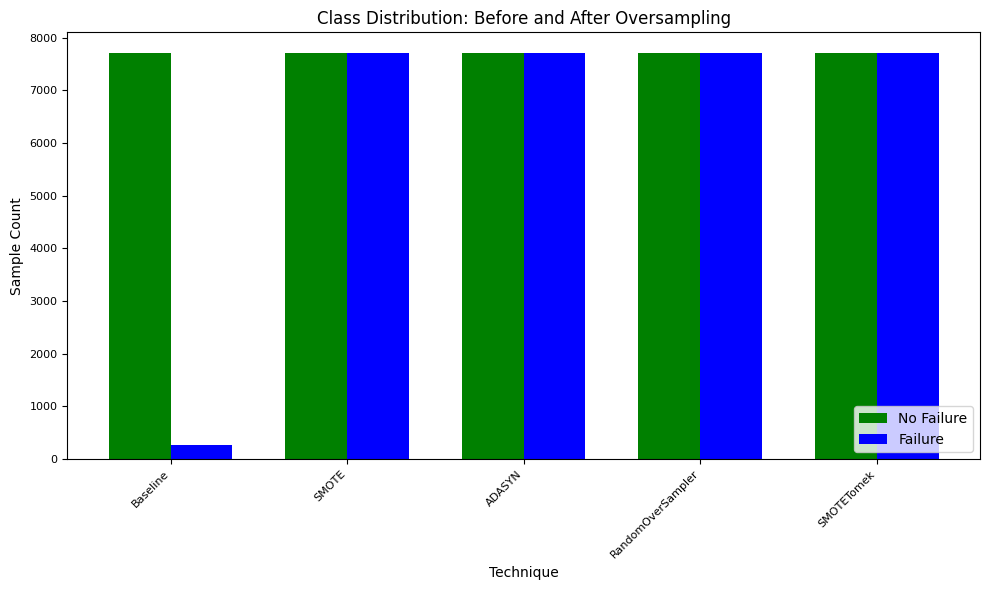

In [45]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 6))

# Prepare data for grouped bar chart
techniques_list = ['Baseline'] + list(techniques.keys())
no_failure_counts = []
failure_counts = []

# Original data
no_failure_counts.append(original_counts[0])
failure_counts.append(original_counts[1])

# Oversampled data
for technique in techniques.keys():
    counts = pd.Series(resampled_datasets[technique]['scaled'][1]).value_counts().sort_index()
    no_failure_counts.append(counts[0])
    failure_counts.append(counts[1])

# Define the x-axis positions
x = np.arange(len(techniques_list))

# Set width
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, no_failure_counts, width, label = 'No Failure', color = 'green')
bars2 = ax.bar(x + width/2, failure_counts, width, label = 'Failure', color = 'blue')

# Set axes labels
ax.set_xlabel('Technique', fontsize = 10, fontweight = 'normal')
ax.set_ylabel('Sample Count', fontsize = 10, fontweight = 'normal')

# Add title
ax.set_title('Class Distribution: Before and After Oversampling', fontsize = 12, fontweight = 'normal')

# Set axes ticks
ax.set_xticks(x)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_xticklabels(techniques_list, rotation = 45, ha = 'right')

# Add legend
ax.legend(loc = 'lower right')

# Grid
ax.grid(False)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

## Train models with oversampled data

In [46]:
# Initialize dictonaries to store results
oversampled_results = {}
oversampled_predictions = {}
oversampled_probabilities = {}
oversampled_training_history = {}

# Train each model with each oversampling technique
for technique_name, data_dict in resampled_datasets.items():
    # Print
    print(f"TRAINING WITH {technique_name.upper()}")
    print(f"{'-'*50}")

    # Train each model
    for model_name, model in models.items():
        # Clone model to ensure fresh start
        model_clone = clone(model)
        combination_key = f"{model_name}_{technique_name}"

        # Print
        print(f"\nTraining {model_name} with {technique_name}:")

        # Select appropriate data based on model type
        if model_name == 'Random Forest':
            X_train_use = data_dict['unscaled'][0]
            y_train_use = data_dict['unscaled'][1]
            X_test_use = X_test_unscaled
            print("  Using: Unscaled data (DataFrame)")
        else:
            X_train_use = data_dict['scaled'][0]
            y_train_use = data_dict['scaled'][1]
            X_test_use = X_test_scaled
            print("  Using: Scaled data (NumPy array)")

        # Train model
        start_time = time.time()

        if model_name == 'MLP Classifier':

            # Split for validation
            X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = tts(
                X_train_use, y_train_use, test_size=0.1, random_state=17, stratify=y_train_use
            )

            # Train epoch by epoch
            model_clone.set_params(warm_start = True, max_iter = 1)
            best_val_score = -np.inf
            no_improvement_count = 0
            epoch_data = []

            # Training loop for up to 200 epochs
            for epoch in range(1, 201):
                # Fit one epoch
                model_clone.fit(X_train_mlp, y_train_mlp)

                # Calculate metrics
                train_pred = model_clone.predict(X_train_mlp)
                train_proba = model_clone.predict_proba(X_train_mlp)[:, 1]
                val_pred = model_clone.predict(X_val_mlp)
                val_proba = model_clone.predict_proba(X_val_mlp)[:, 1]

                # Calculate loss and performance metrics
                train_loss = log_loss(y_train_mlp, train_proba)
                val_loss = log_loss(y_val_mlp, val_proba)
                train_f1 = f1_score(y_train_mlp, train_pred, zero_division = 0)
                train_recall = recall_score(y_train_mlp, train_pred, zero_division = 0)
                val_f1 = f1_score(y_val_mlp, val_pred, zero_division = 0)
                val_recall = recall_score(y_val_mlp, val_pred, zero_division = 0)

                # Print epoch results
                print(f"  Epoch {epoch} - loss: {train_loss:.4f} - f1_score: {train_f1:.4f} - "
                      f"recall: {train_recall:.4f} - val_loss: {val_loss:.4f} - "
                      f"val_f1_score: {val_f1:.4f} - val_recall: {val_recall:.4f} - "
                      f"learning_rate: {model_clone.learning_rate_init:.4f}")

                # Store epoch data
                epoch_data.append({
                    'epoch': epoch,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_f1': train_f1,
                    'val_f1': val_f1,
                    'train_recall': train_recall,
                    'val_recall': val_recall
                })

                # Early stopping check
                val_score = val_f1
                if val_score > best_val_score + 0.0001:
                    best_val_score = val_score
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count >= 5:
                    print(f"  Validation score did not improve for 5 consecutive epochs. Stopping.")
                    break

            # Store training history
            oversampled_training_history[combination_key] = {
                'n_iter': epoch,
                'epoch_data': epoch_data
            }

        else:
            # For Random Forest and KNN
            model_clone.fit(X_train_use, y_train_use)

        # Calculate training time
        training_time = time.time() - start_time

        # Make predictions
        y_pred = model_clone.predict(X_test_use)
        y_proba = model_clone.predict_proba(X_test_use)[:, 1]

        # Calculate metrics
        loss = log_loss(y_test, y_proba)

        # Store predictions and probabilities
        oversampled_predictions[combination_key] = y_pred
        oversampled_probabilities[combination_key] = y_proba

        # Calculate all metrics
        metrics = {
            'Model': model_name,
            'Oversampling': technique_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division = 0),
            'Recall': recall_score(y_test, y_pred, zero_division = 0),
            'F1-Score': f1_score(y_test, y_pred, zero_division = 0),
            'ROC-AUC': roc_auc_score(y_test, y_proba),
            'Loss': loss
        }

        # Store results
        oversampled_results[combination_key] = metrics

        # Print results for RF and KNN
        if model_name in ['Random Forest', 'KNN']:
            print(f"  Result - "
                  f"loss: {loss:.4f} - f1_score: {metrics['F1-Score']:.4f} - recall: {metrics['Recall']:.4f} - "
                  f"val_loss: {loss:.4f} - val_f1_score: {metrics['F1-Score']:.4f} - val_recall: {metrics['Recall']:.4f} - "
                  f"learning_rate: 0.0000e+00")

# Display comprehensive results
print("\nOVERSAMPLED MODEL PERFORMANCE SUMMARY")
print("-"*80)

# Create results DataFrame
oversampled_results_df = pd.DataFrame.from_dict(oversampled_results, orient = 'index')

# Style the results table
styled_results_table = (
    oversampled_results_df.style
    .hide(axis = "index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}',
        'ROC-AUC': '{:.4f}',
        'Loss': '{:.4f}'
    })
    .set_caption("Oversampled Models Performance Matrix")
)

# Display the table
display(styled_results_table)

TRAINING WITH SMOTE
--------------------------------------------------

Training Random Forest with SMOTE:
  Using: Unscaled data (DataFrame)
  Result - loss: 0.0796 - f1_score: 0.5934 - recall: 0.8182 - val_loss: 0.0796 - val_f1_score: 0.5934 - val_recall: 0.8182 - learning_rate: 0.0000e+00

Training MLP Classifier with SMOTE:
  Using: Scaled data (NumPy array)
  Epoch 1 - loss: 0.2741 - f1_score: 0.8775 - recall: 0.8652 - val_loss: 0.2685 - val_f1_score: 0.8831 - val_recall: 0.8756 - learning_rate: 0.0010
  Epoch 2 - loss: 0.1894 - f1_score: 0.9264 - recall: 0.9453 - val_loss: 0.1955 - val_f1_score: 0.9185 - val_recall: 0.9339 - learning_rate: 0.0010
  Epoch 3 - loss: 0.1536 - f1_score: 0.9440 - recall: 0.9644 - val_loss: 0.1639 - val_f1_score: 0.9344 - val_recall: 0.9495 - learning_rate: 0.0010
  Epoch 4 - loss: 0.1310 - f1_score: 0.9568 - recall: 0.9785 - val_loss: 0.1457 - val_f1_score: 0.9544 - val_recall: 0.9767 - learning_rate: 0.0010
  Epoch 5 - loss: 0.1157 - f1_score: 0.9618

Model,Oversampling,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Loss
Random Forest,SMOTE,0.9629,0.4655,0.8182,0.5934,0.9820,0.0796
MLP Classifier,SMOTE,0.9629,0.4643,0.7879,0.5843,0.9788,0.1153
KNN,SMOTE,0.9424,0.3333,0.7424,0.4601,0.8904,0.9947
Random Forest,ADASYN,0.9624,0.4615,0.8182,0.5902,0.9775,0.0867
MLP Classifier,ADASYN,0.9589,0.4375,0.8485,0.5773,0.9777,0.1461
KNN,ADASYN,0.9388,0.3205,0.7576,0.4505,0.8962,1.1198
Random Forest,RandomOverSampler,0.9860,0.8519,0.6970,0.7667,0.9860,0.0471
MLP Classifier,RandomOverSampler,0.9649,0.4818,0.8030,0.6023,0.9815,0.1156
KNN,RandomOverSampler,0.9599,0.4314,0.6667,0.5238,0.8617,0.8094
Random Forest,SMOTETomek,0.9629,0.4636,0.7727,0.5795,0.9782,0.0842


##Performance Comparison

In [47]:
# Combined Results DataFrame

# Create list to store baseline results
baseline_data = []

# Extract baseline results for each model
for model_name, metrics in baseline_results.items():

    # Format baseline results
    baseline_data.append({
        'Model': model_name,
        'Technique': 'Baseline',
        'F1-Score': metrics['F1-Score'],
        'Recall': metrics['Recall'],
        'ROC-AUC': metrics['ROC-AUC'],
        'Loss': metrics['Loss']
    })

# Convert baseline results to DataFrame
baseline_df = pd.DataFrame(baseline_data)

# Extract oversampled results and format consistently
oversampled_df = pd.DataFrame.from_dict(oversampled_results, orient = 'index')[
    ['Model', 'Oversampling', 'F1-Score', 'Recall', 'ROC-AUC', 'Loss']
].rename(columns = {'Oversampling': 'Technique'})

# Combine baseline and oversampled results into single DataFrame
all_results = pd.concat([baseline_df, oversampled_df], ignore_index = True)

# Print combined results
print("\n" + "="*80)
print("COMBINED RESULTS - BASELINE AND OVERSAMPLING TECHNIQUES")
print("="*80)

# Display the combined results DataFrame
print("\nAll Results Summary:")
print(all_results.to_string(index=False))

# Create styled table for better visualization
styled_all_results = (
    all_results.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'F1-Score': '{:.4f}',
        'Recall': '{:.4f}',
        'ROC-AUC': '{:.4f}',
        'Loss': '{:.4f}'
    })
    .set_caption("Combined Performance Matrix: Baseline vs Oversampling Techniques")
)

# Display the styled table
display(styled_all_results)

# Print summary statistics
print("\n" + "-"*80)
print("SUMMARY STATISTICS")
print("-"*80)

# Group by model and find best technique for each
for model in all_results['Model'].unique():
    model_results = all_results[all_results['Model'] == model]
    best_row = model_results.loc[model_results['F1-Score'].idxmax()]

    print(f"\n{model}:")
    print(f"  Best Technique: {best_row['Technique']}")
    print(f"  Best F1-Score: {best_row['F1-Score']:.4f}")
    print(f"  Best Recall: {best_row['Recall']:.4f}")


COMBINED RESULTS - BASELINE AND OVERSAMPLING TECHNIQUES

All Results Summary:
         Model         Technique  F1-Score   Recall  ROC-AUC     Loss
 Random Forest          Baseline  0.714286 0.606061 0.972481 0.077726
MLP Classifier          Baseline  0.644628 0.590909 0.979280 0.057380
           KNN          Baseline  0.444444 0.303030 0.865895 0.324036
 Random Forest             SMOTE  0.593407 0.818182 0.981966 0.079586
MLP Classifier             SMOTE  0.584270 0.787879 0.978761 0.115298
           KNN             SMOTE  0.460094 0.742424 0.890409 0.994687
 Random Forest            ADASYN  0.590164 0.818182 0.977508 0.086663
MLP Classifier            ADASYN  0.577320 0.848485 0.977748 0.146108
           KNN            ADASYN  0.450450 0.757576 0.896225 1.119769
 Random Forest RandomOverSampler  0.766667 0.696970 0.985968 0.047139
MLP Classifier RandomOverSampler  0.602273 0.803030 0.981479 0.115624
           KNN RandomOverSampler  0.523810 0.666667 0.861653 0.809391
 Random For

Model,Technique,F1-Score,Recall,ROC-AUC,Loss
Random Forest,Baseline,0.7143,0.6061,0.9725,0.0777
MLP Classifier,Baseline,0.6446,0.5909,0.9793,0.0574
KNN,Baseline,0.4444,0.3030,0.8659,0.3240
Random Forest,SMOTE,0.5934,0.8182,0.9820,0.0796
MLP Classifier,SMOTE,0.5843,0.7879,0.9788,0.1153
KNN,SMOTE,0.4601,0.7424,0.8904,0.9947
Random Forest,ADASYN,0.5902,0.8182,0.9775,0.0867
MLP Classifier,ADASYN,0.5773,0.8485,0.9777,0.1461
KNN,ADASYN,0.4505,0.7576,0.8962,1.1198
Random Forest,RandomOverSampler,0.7667,0.6970,0.9860,0.0471



--------------------------------------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------------------------------------

Random Forest:
  Best Technique: RandomOverSampler
  Best F1-Score: 0.7667
  Best Recall: 0.6970

MLP Classifier:
  Best Technique: Baseline
  Best F1-Score: 0.6446
  Best Recall: 0.5909

KNN:
  Best Technique: RandomOverSampler
  Best F1-Score: 0.5238
  Best Recall: 0.6667


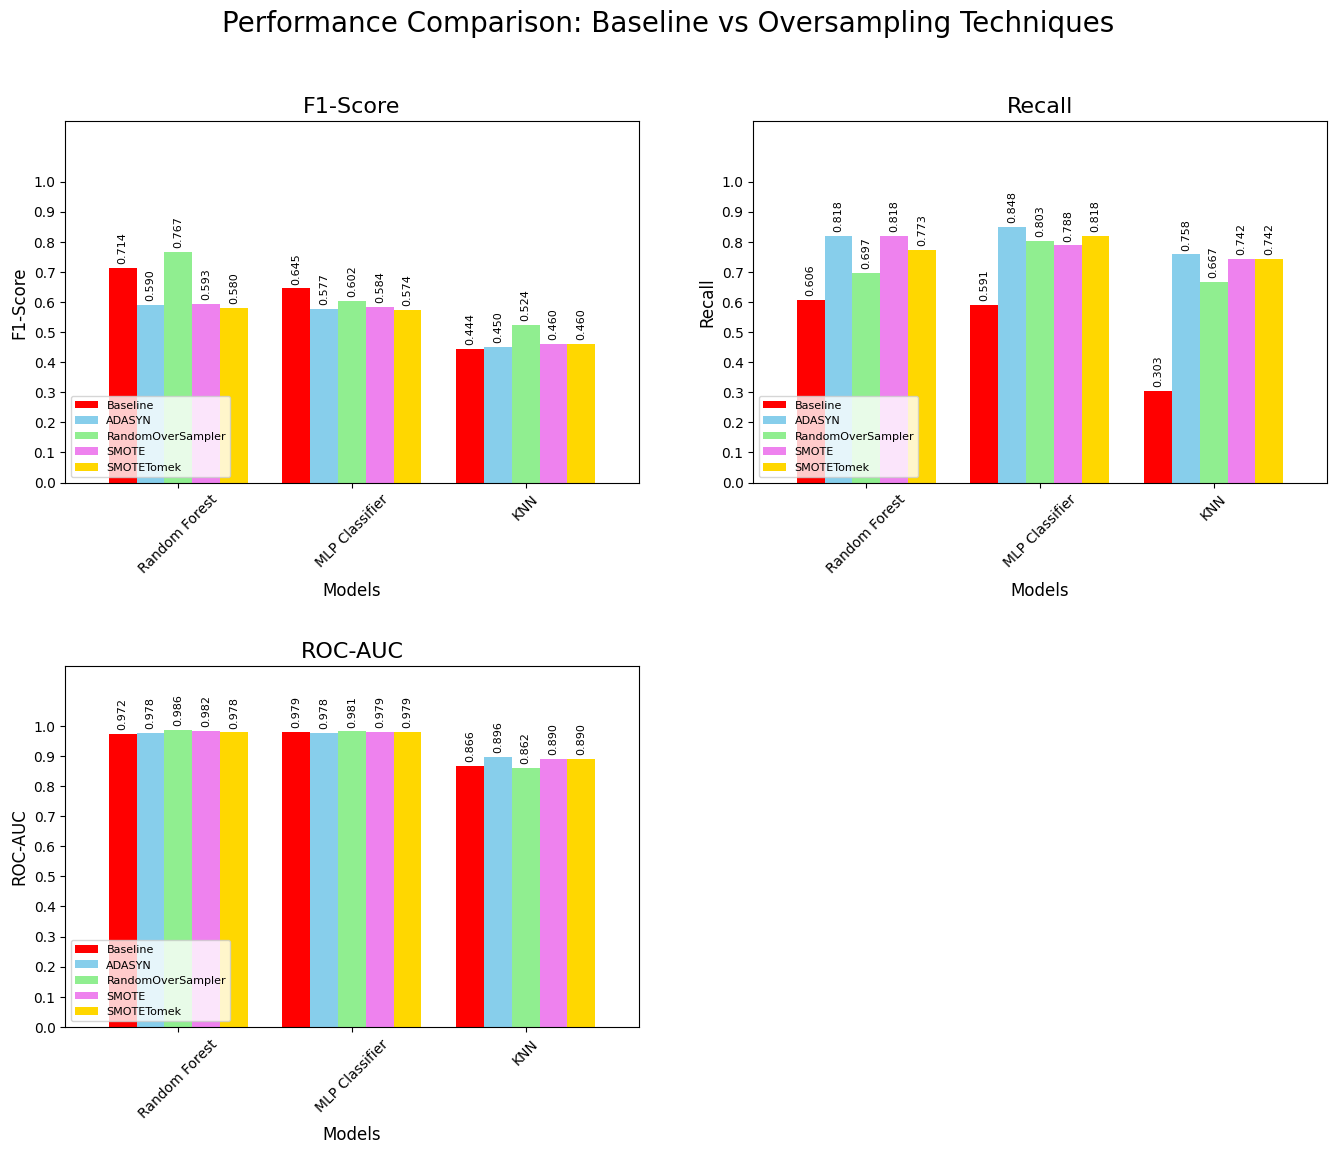

In [48]:
# Performance Comparison Visualizations (without Loss)

# Create figure
fig, axes = plt.subplots(2, 2, figsize = (14, 12))

# Add main title
fig.suptitle('Performance Comparison: Baseline vs Oversampling Techniques',
             fontsize = 20, fontweight = 'normal')

# Define metrics to plot and color scheme
metrics_to_plot = ['F1-Score', 'Recall', 'ROC-AUC']
colors = ['red', 'skyblue', 'lightgreen', 'violet', 'gold']

# Create bar plots for each metric
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i // 2, i % 2]

    # Pivot data to create grouped bar chart format
    pivot_data = all_results.pivot(index = 'Model', columns = 'Technique', values = metric)

    # Reorder models
    model_order = ['Random Forest', 'MLP Classifier', 'KNN']
    pivot_data = pivot_data.reindex(index = [model for model in model_order if model in pivot_data.index])

    # Define column order for consistent display
    column_order = ['Baseline', 'ADASYN', 'RandomOverSampler', 'SMOTE', 'SMOTETomek']
    pivot_data = pivot_data.reindex(columns = [col for col in column_order if col in pivot_data.columns])

    # Create grouped bar chart
    bars = pivot_data.plot(kind = 'bar', ax = ax, width = 0.8, color = colors[:len(pivot_data.columns)])

    # Set subplot title
    ax.set_title(f'{metric}', fontsize = 16, fontweight = 'normal')

    # Set axes labels
    ax.set_xlabel('Models', fontweight = 'normal', fontsize = 12)
    ax.set_ylabel(metric, fontweight = 'normal', fontsize = 12)

    # Add leged
    ax.legend(loc = 'lower left', fontsize = 8)

    # Add axes ticks
    ax.tick_params(axis = 'x', rotation = 45, labelsize = 10)
    ax.tick_params(axis = 'y', labelsize = 10)

    # Grid
    ax.grid(False)

    # Set y-axis limits and ticks
    ax.set_ylim(0, 1.2)
    ax.set_yticks(np.arange(0, 1.1, 0.1))

    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt = '%.3f', fontsize = 8, rotation = 90, padding = 3)

# Delete 4th subplot
plt.delaxes(axes[1, 1])

# Adjust layout
plt.tight_layout(pad = 3.0)

# Adjust spacing between subplots
plt.subplots_adjust(wspace = 0.2)

# Display the plot
plt.show()

##Confusion Matrices - Best Performing Combinations

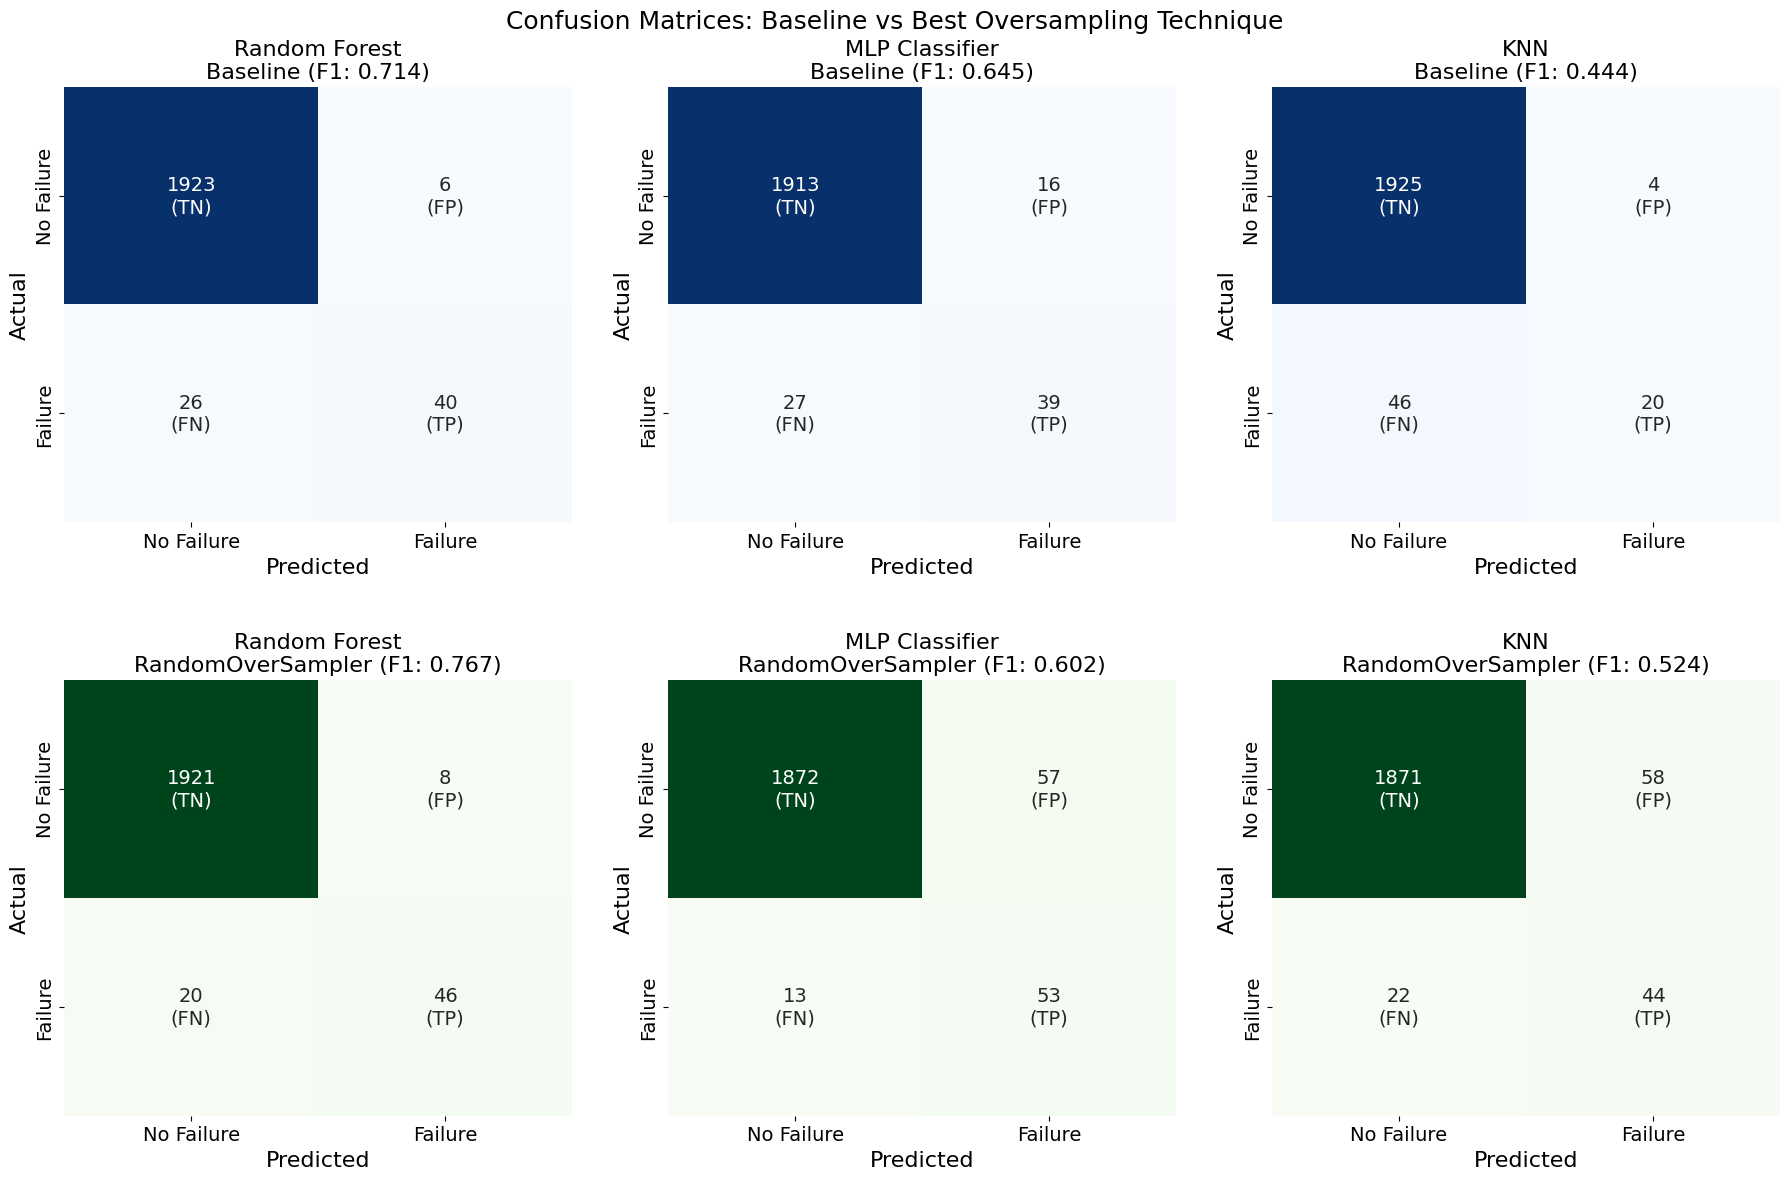


--------------------------------------------------------------------------------
CONFUSION MATRIX ANALYSIS - BEST PERFORMING COMBINATIONS
--------------------------------------------------------------------------------

Random Forest:
  Best Technique: RandomOverSampler
  Baseline → Best Oversampling:
    True Positives:  40 → 46 (+6)
    False Negatives: 26 → 20 (-6)
    False Positives: 6 → 8 (+2)
    True Negatives:  1923 → 1921 (-2)
    Failure Detection Rate: 60.61% → 69.70% (+15.0% improvement)

MLP Classifier:
  Best Technique: RandomOverSampler
  Baseline → Best Oversampling:
    True Positives:  39 → 53 (+14)
    False Negatives: 27 → 13 (-14)
    False Positives: 16 → 57 (+41)
    True Negatives:  1913 → 1872 (-41)
    Failure Detection Rate: 59.09% → 80.30% (+35.9% improvement)

KNN:
  Best Technique: RandomOverSampler
  Baseline → Best Oversampling:
    True Positives:  20 → 44 (+24)
    False Negatives: 46 → 22 (-24)
    False Positives: 4 → 58 (+54)
    True Negatives:  

Model,Best_Technique,Baseline_TP,Baseline_FN,Baseline_Recall,Best_TP,Best_FN,Best_Recall,TP_Improvement,FN_Reduction
Random Forest,RandomOverSampler,40,26,60.61%,46,20,69.70%,6,6
MLP Classifier,RandomOverSampler,39,27,59.09%,53,13,80.30%,14,14
KNN,RandomOverSampler,20,46,30.30%,44,22,66.67%,24,24


In [50]:
# Get list of model names
model_names = list(models.keys())

# Find best performing oversampling technique for each model
best_combinations = {}
for model_name in model_names:
    # Filter results for current model
    model_results = {k: v for k, v in oversampled_results.items() if v['Model'] == model_name}
    # Find technique with highest F1-Score
    best_key = max(model_results.keys(), key = lambda k: model_results[k]['F1-Score'])
    # Store best combination details
    best_combinations[model_name] = {
        'key': best_key,
        'technique': model_results[best_key]['Oversampling'],
        'f1_score': model_results[best_key]['F1-Score']
    }

# Create confusion matrices for baseline and best oversampling
fig, axes = plt.subplots(2, 3, figsize = (18, 12))

# Add main title
fig.suptitle('Confusion Matrices: Baseline vs Best Oversampling Technique', fontsize = 18, fontweight = 'normal')

# Row 1: Baseline confusion matrices
for idx, model_name in enumerate(model_names):
    ax = axes[0, idx]

    # Baseline confusion matrix
    y_pred = baseline_predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Create annotations with labels
    annotations = [[f'{tn}\n(TN)', f'{fp}\n(FP)'],
                   [f'{fn}\n(FN)', f'{tp}\n(TP)']]

    # Plot heatmap
    sns.heatmap(cm, annot = annotations, fmt = '', cmap = 'Blues',
                ax = ax, cbar = False,
                xticklabels = ['No Failure', 'Failure'],
                yticklabels = ['No Failure', 'Failure'],
                annot_kws = {'size': 14})

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = baseline_results[model_name]['F1-Score']

    # Set title and labels
    ax.set_title(f'{model_name}\nBaseline (F1: {f1:.3f})', fontsize = 16, fontweight = 'normal')
    ax.set_xlabel('Predicted', fontsize = 16, fontweight = 'normal')
    ax.set_ylabel('Actual', fontsize = 16, fontweight = 'normal')
    ax.tick_params(axis = 'x', labelsize = 14)
    ax.tick_params(axis = 'y', labelsize = 14)

# Row 2: Best oversampling technique confusion matrices
for idx, model_name in enumerate(model_names):
    ax = axes[1, idx]

    # Best oversampling confusion matrix
    best_key = best_combinations[model_name]['key']
    best_technique = best_combinations[model_name]['technique']
    best_f1 = best_combinations[model_name]['f1_score']

    y_pred = oversampled_predictions[best_key]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Create annotations with labels
    annotations = [[f'{tn}\n(TN)', f'{fp}\n(FP)'],
                   [f'{fn}\n(FN)', f'{tp}\n(TP)']]

    # Plot heatmap with different color
    sns.heatmap(cm, annot = annotations, fmt = '', cmap = 'Greens',
                ax = ax, cbar = False,
                xticklabels = ['No Failure', 'Failure'],
                yticklabels = ['No Failure', 'Failure'],
                annot_kws = {'size': 14})

    # Set title and labels
    ax.set_title(f'{model_name}\n{best_technique} (F1: {best_f1:.3f})',
                 fontsize = 16, fontweight = 'normal')
    ax.set_xlabel('Predicted', fontsize = 16, fontweight = 'normal')
    ax.set_ylabel('Actual', fontsize = 16, fontweight = 'normal')
    ax.tick_params(axis = 'x', labelsize = 14)
    ax.tick_params(axis = 'y', labelsize = 14)

# Adjust layout
plt.tight_layout(h_pad = 4.0, w_pad = 3.0)

# Display the plot
plt.show()

# Print summary of improvements
print("\n" + "-"*80)
print("CONFUSION MATRIX ANALYSIS - BEST PERFORMING COMBINATIONS")
print("-"*80)

# Analyze improvements for each model
for model_name in model_names:
    print(f"\n{model_name}:")

    # Baseline metrics
    baseline_cm = confusion_matrix(y_test, baseline_predictions[model_name])
    tn_base, fp_base, fn_base, tp_base = baseline_cm.ravel()

    # Best oversampling metrics
    best_key = best_combinations[model_name]['key']
    best_technique = best_combinations[model_name]['technique']
    best_cm = confusion_matrix(y_test, oversampled_predictions[best_key])
    tn_best, fp_best, fn_best, tp_best = best_cm.ravel()

    # Print comparison
    print(f"  Best Technique: {best_technique}")
    print(f"  Baseline → Best Oversampling:")
    print(f"    True Positives:  {tp_base} → {tp_best} ({tp_best - tp_base:+d})")
    print(f"    False Negatives: {fn_base} → {fn_best} ({fn_best - fn_base:+d})")
    print(f"    False Positives: {fp_base} → {fp_best} ({fp_best - fp_base:+d})")
    print(f"    True Negatives:  {tn_base} → {tn_best} ({tn_best - tn_base:+d})")

    # Calculate improvement in failure detection
    baseline_recall = tp_base / (tp_base + fn_base) if (tp_base + fn_base) > 0 else 0
    best_recall = tp_best / (tp_best + fn_best) if (tp_best + fn_best) > 0 else 0
    recall_improvement = (best_recall - baseline_recall) / baseline_recall * 100 if baseline_recall > 0 else 0

    # Print
    print(f"    Failure Detection Rate: {baseline_recall:.2%} → {best_recall:.2%} "
          f"({recall_improvement:+.1f}% improvement)")

# Create a summary table
summary_data = []
for model_name in model_names:
    # Baseline confusion matrix values
    baseline_cm = confusion_matrix(y_test, baseline_predictions[model_name])
    tn_base, fp_base, fn_base, tp_base = baseline_cm.ravel()

    # Best oversampling confusion matrix values
    best_key = best_combinations[model_name]['key']
    best_technique = best_combinations[model_name]['technique']
    best_cm = confusion_matrix(y_test, oversampled_predictions[best_key])
    tn_best, fp_best, fn_best, tp_best = best_cm.ravel()

    # Compile summary statistics
    summary_data.append({
        'Model': model_name,
        'Best_Technique': best_technique,
        'Baseline_TP': tp_base,
        'Baseline_FN': fn_base,
        'Baseline_Recall': tp_base / (tp_base + fn_base) if (tp_base + fn_base) > 0 else 0,
        'Best_TP': tp_best,
        'Best_FN': fn_best,
        'Best_Recall': tp_best / (tp_best + fn_best) if (tp_best + fn_best) > 0 else 0,
        'TP_Improvement': tp_best - tp_base,
        'FN_Reduction': fn_base - fn_best
    })

# Create DataFrame from summary data
summary_df = pd.DataFrame(summary_data)

# Style the summary table
styled_summary = (
    summary_df.style
    .hide(axis = "index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'Baseline_Recall': '{:.2%}',
        'Best_Recall': '{:.2%}'
    })
    .set_caption("Failure Detection Improvement Summary")
)

# Display the table
display(styled_summary)

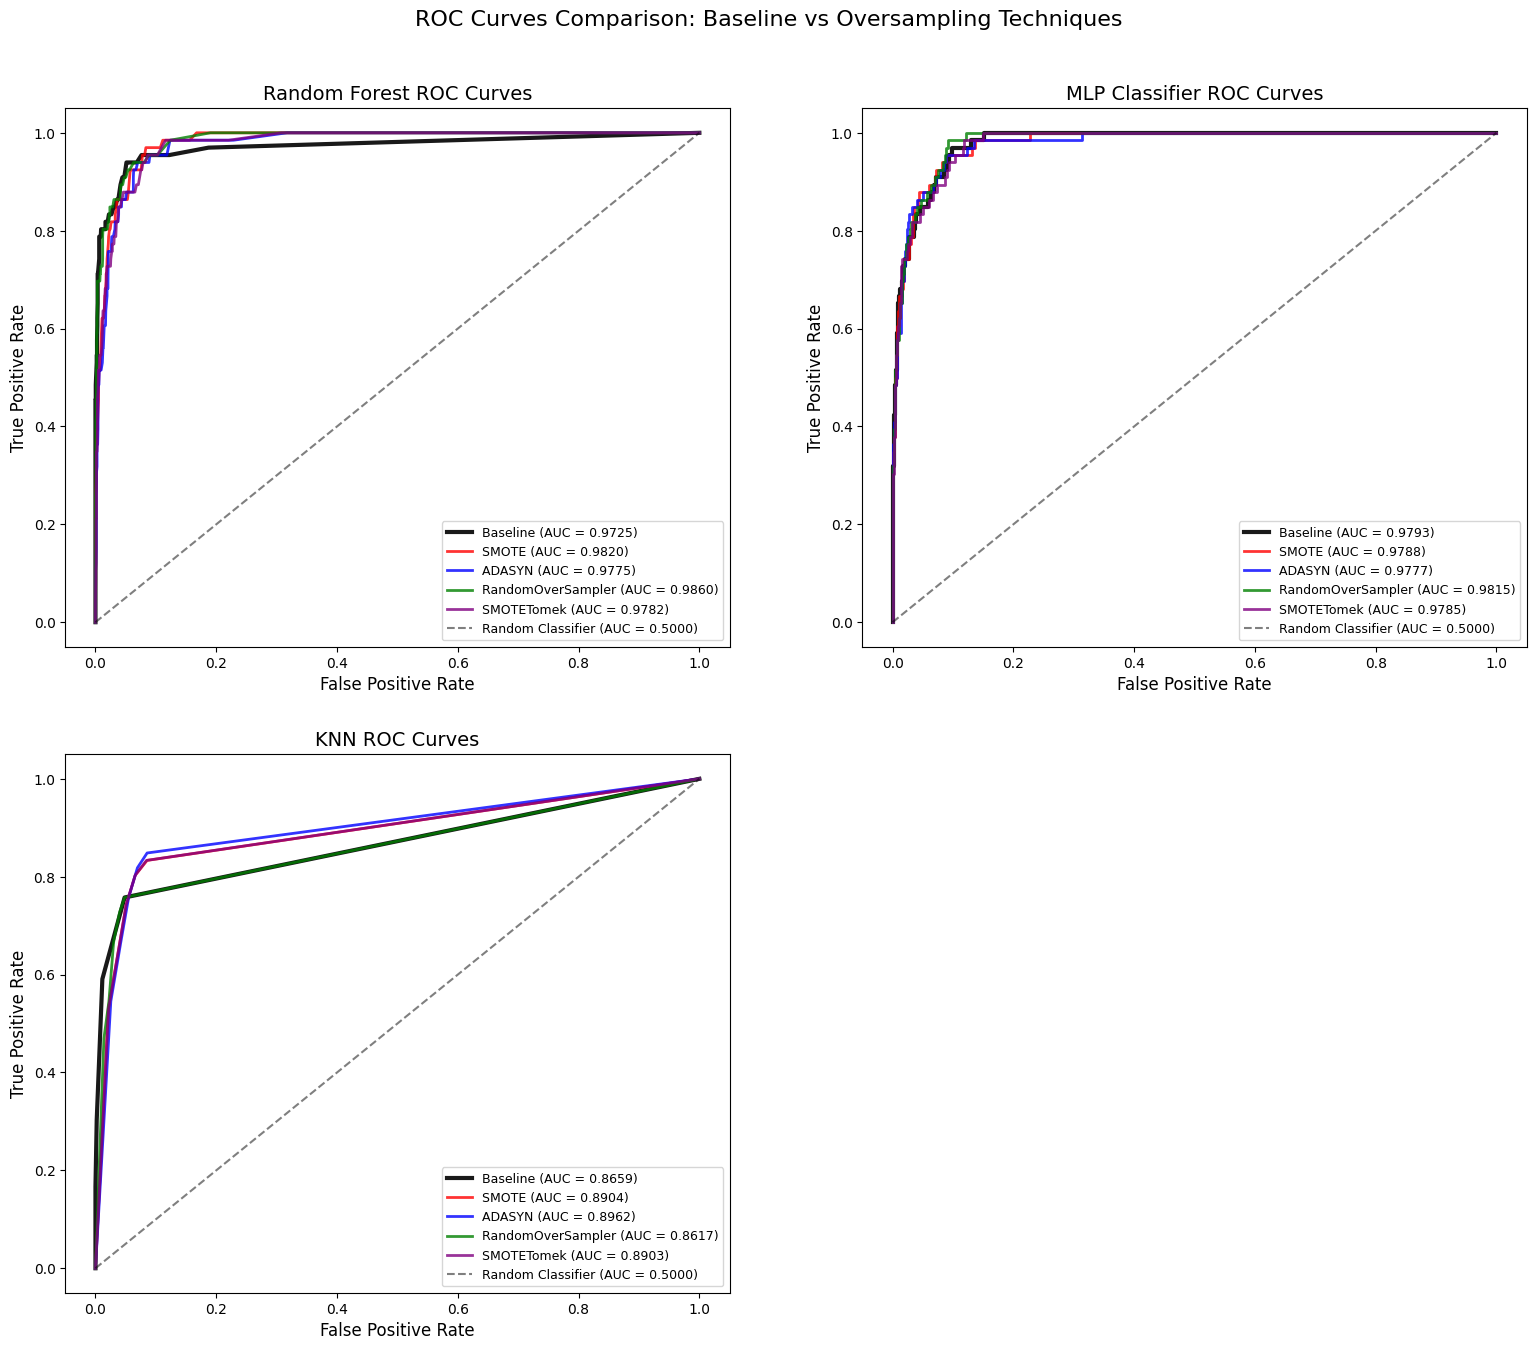

In [51]:
# ROC Curves Comparison - All Models and Techniques

# Create figure
fig, axes = plt.subplots(2, 2, figsize = (16, 14))

# Add main title
fig.suptitle('ROC Curves Comparison: Baseline vs Oversampling Techniques',
             fontsize = 16, fontweight = 'normal')

# Flatten axes
axes_flat = axes.flatten()

# Iterate through model names along with their index
for i, model_name in enumerate(model_names):
    ax = axes_flat[i]

    # Plot baseline ROC curve
    y_proba_baseline = baseline_probabilities[model_name]
    fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline)
    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)
    ax.plot(fpr_baseline, tpr_baseline, label = f'Baseline (AUC = {roc_auc_baseline:.4f})',
            linewidth = 3, alpha = 0.9, color = 'black', linestyle = '-')

    # Choose colors
    colors_roc = ['red', 'blue', 'green', 'purple']

    # Plot ROC curves for each oversampling technique
    for j, technique_name in enumerate(techniques.keys()):
        combination_key = f"{model_name}_{technique_name}"
        y_proba = oversampled_probabilities[combination_key]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc_value = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = f'{technique_name} (AUC = {roc_auc_value:.4f})',
                linewidth = 2, alpha = 0.8, color = colors_roc[j])

    # Plot diagonal line
    ax.plot([0, 1], [0, 1], 'k--', alpha = 0.5, label = 'Random Classifier (AUC = 0.5000)')

    # Add subplot title
    ax.set_title(f'{model_name} ROC Curves', fontsize = 14, fontweight = 'normal')

    # Add axes labels
    ax.set_xlabel('False Positive Rate', fontsize = 12)
    ax.set_ylabel('True Positive Rate', fontsize = 12)

    # Add legend
    ax.legend(loc = 'lower right', fontsize = 9)

    # Grid
    ax.grid(False)

# Remove empty subplot
axes_flat[3].axis('off')

# Adjust layout
plt.tight_layout(pad = 3.0)

# Increase padding
plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

# Display plot
plt.show()

## Hyperparameter Tuning

In [52]:
# Identify best performing combinations for tuning
results_df = pd.DataFrame.from_dict(oversampled_results, orient = 'index')
best_performers = []

# Iterate through each model in the list of model names
for model_name in model_names:
    model_results = results_df[results_df['Model'] == model_name]
    best_idx = model_results['F1-Score'].idxmax()
    best_technique = model_results.loc[best_idx, 'Oversampling']
    best_performers.append((model_name, best_technique))

# Print
print("\nBEST COMBINATIONS SELECTED FOR TUNING:")
for model, technique in best_performers:
    print(f"  {model} + {technique}")

# Define hyperparameter grids
hyperparameter_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'MLP Classifier': {
        'hidden_layer_sizes': [(50,), (100,), (128, 64), (128, 64, 32)],
        'alpha': [0.001, 0.01, 0.1],
        'learning_rate_init': [0.001, 0.01]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    }
}

# Perform hyperparameter tuning
tuned_results = {}
tuned_predictions = {}
tuned_probabilities = {}
tuning_summary = []

# Iterate through each model and its corresponding best performing oversampling technique
for model_name, best_technique in best_performers:
    print(f"\nTuning {model_name} with {best_technique}:")

    # Get resampled data
    if model_name == 'Random Forest':
        X_resampled = resampled_datasets[best_technique]['unscaled'][0]
        X_test_use = X_test_unscaled
    else:
        X_resampled = resampled_datasets[best_technique]['scaled'][0]
        X_test_use = X_test_scaled

    y_resampled = resampled_datasets[best_technique]['scaled'][1]

    # Initialize model
    if model_name == 'KNN':
        base_model = KNeighborsClassifier()
    elif model_name == 'MLP Classifier':
        base_model = MLPClassifier(random_state = 17, max_iter = 200)
    else:
        base_model = RandomForestClassifier(random_state = 17)

    # Grid search
    grid_search = GridSearchCV(
        base_model,
        hyperparameter_grids[model_name],
        cv = 3,
        scoring = 'f1',
        n_jobs = -1
    )

    start_time = time.time()
    grid_search.fit(X_resampled, y_resampled)
    tuning_time = time.time() - start_time

    # Get best model and predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_use)
    y_proba = best_model.predict_proba(X_test_use)[:, 1]

    # Calculate metrics
    test_f1 = f1_score(y_test, y_pred, zero_division = 0)
    combination_key = f"{model_name}_{best_technique}_tuned"
    tuned_results[combination_key] = {
        'Model': model_name,
        'Technique': f"{best_technique} (Tuned)",
        'Best_Params': grid_search.best_params_,
        'CV_Score': grid_search.best_score_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division = 0),
        'Recall': recall_score(y_test, y_pred, zero_division = 0),
        'F1-Score': test_f1,
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Loss': log_loss(y_test, y_proba)
    }

    # Store predictions in a dictionary
    tuned_predictions[combination_key] = y_pred
    tuned_probabilities[combination_key] = y_proba

    # Add to tuning summary
    tuning_summary.append({
        'Model': model_name,
        'Technique': best_technique,
        'CV_F1_Score': grid_search.best_score_,
        'Test_F1_Score': test_f1,
        'Best_Parameters': str(grid_search.best_params_)
    })

    # Print
    print(f"  Best params: {grid_search.best_params_}")
    print(f"  CV F1-Score: {grid_search.best_score_:.4f}")
    print(f"  Test F1-Score: {test_f1:.4f}")

# Display tuning summary table
print("\n" + "-"*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("-"*80)

# Create DataFrame
tuning_df = pd.DataFrame(tuning_summary)

# Style the table
styled_tuning_table = (
    tuning_df.style
    .hide(axis = "index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'CV_F1_Score': '{:.4f}',
        'Test_F1_Score': '{:.4f}',
        'Tuning_Time_s': '{:.1f}'
    })
    .set_caption("Hyperparameter Optimization Results")
)

# Display the table
display(styled_tuning_table)


BEST COMBINATIONS SELECTED FOR TUNING:
  Random Forest + RandomOverSampler
  MLP Classifier + RandomOverSampler
  KNN + RandomOverSampler

Tuning Random Forest with RandomOverSampler:
  Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
  CV F1-Score: 0.9959
  Test F1-Score: 0.7667

Tuning MLP Classifier with RandomOverSampler:
  Best params: {'alpha': 0.01, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}
  CV F1-Score: 0.9909
  Test F1-Score: 0.6923

Tuning KNN with RandomOverSampler:
  Best params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
  CV F1-Score: 0.9856
  Test F1-Score: 0.5000

--------------------------------------------------------------------------------
HYPERPARAMETER TUNING SUMMARY
--------------------------------------------------------------------------------


Model,Technique,CV_F1_Score,Test_F1_Score,Best_Parameters
Random Forest,RandomOverSampler,0.9959,0.7667,"{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}"
MLP Classifier,RandomOverSampler,0.9909,0.6923,"{'alpha': 0.01, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}"
KNN,RandomOverSampler,0.9856,0.5000,"{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}"


##Comprehensive Comparison - All Stages

In [53]:
# Create complete results DataFrame
all_stage_results = []

# Add baseline results
for model_name, metrics in baseline_results.items():
    all_stage_results.append({
        'Model': model_name,
        'Stage': 'Baseline',
        'Technique': 'None',
        'F1-Score': metrics['F1-Score'],
        'Recall': metrics['Recall'],
        'ROC-AUC': metrics['ROC-AUC'],
        'Loss': metrics['Loss']
    })

# Add oversampled results
for key, metrics in oversampled_results.items():
    all_stage_results.append({
        'Model': metrics['Model'],
        'Stage': 'Oversampled',
        'Technique': metrics['Oversampling'],
        'F1-Score': metrics['F1-Score'],
        'Recall': metrics['Recall'],
        'ROC-AUC': metrics['ROC-AUC'],
        'Loss': metrics['Loss']
    })

# Add tuned results
for key, metrics in tuned_results.items():
    all_stage_results.append({
        'Model': metrics['Model'],
        'Stage': 'Tuned',
        'Technique': metrics['Technique'],
        'F1-Score': metrics['F1-Score'],
        'Recall': metrics['Recall'],
        'ROC-AUC': metrics['ROC-AUC'],
        'Loss': metrics['Loss']
    })

# Create DataFrame
all_stage_df = pd.DataFrame(all_stage_results)

# Show count of experiments
print(f"\nTotal experiments conducted: {len(all_stage_df)}")
print(f"- Baseline experiments: {len(all_stage_df[all_stage_df['Stage']=='Baseline'])}")
print(f"- Oversampling experiments: {len(all_stage_df[all_stage_df['Stage']=='Oversampled'])}")
print(f"- Tuning experiments: {len(all_stage_df[all_stage_df['Stage']=='Tuned'])}")


Total experiments conducted: 18
- Baseline experiments: 3
- Oversampling experiments: 12
- Tuning experiments: 3


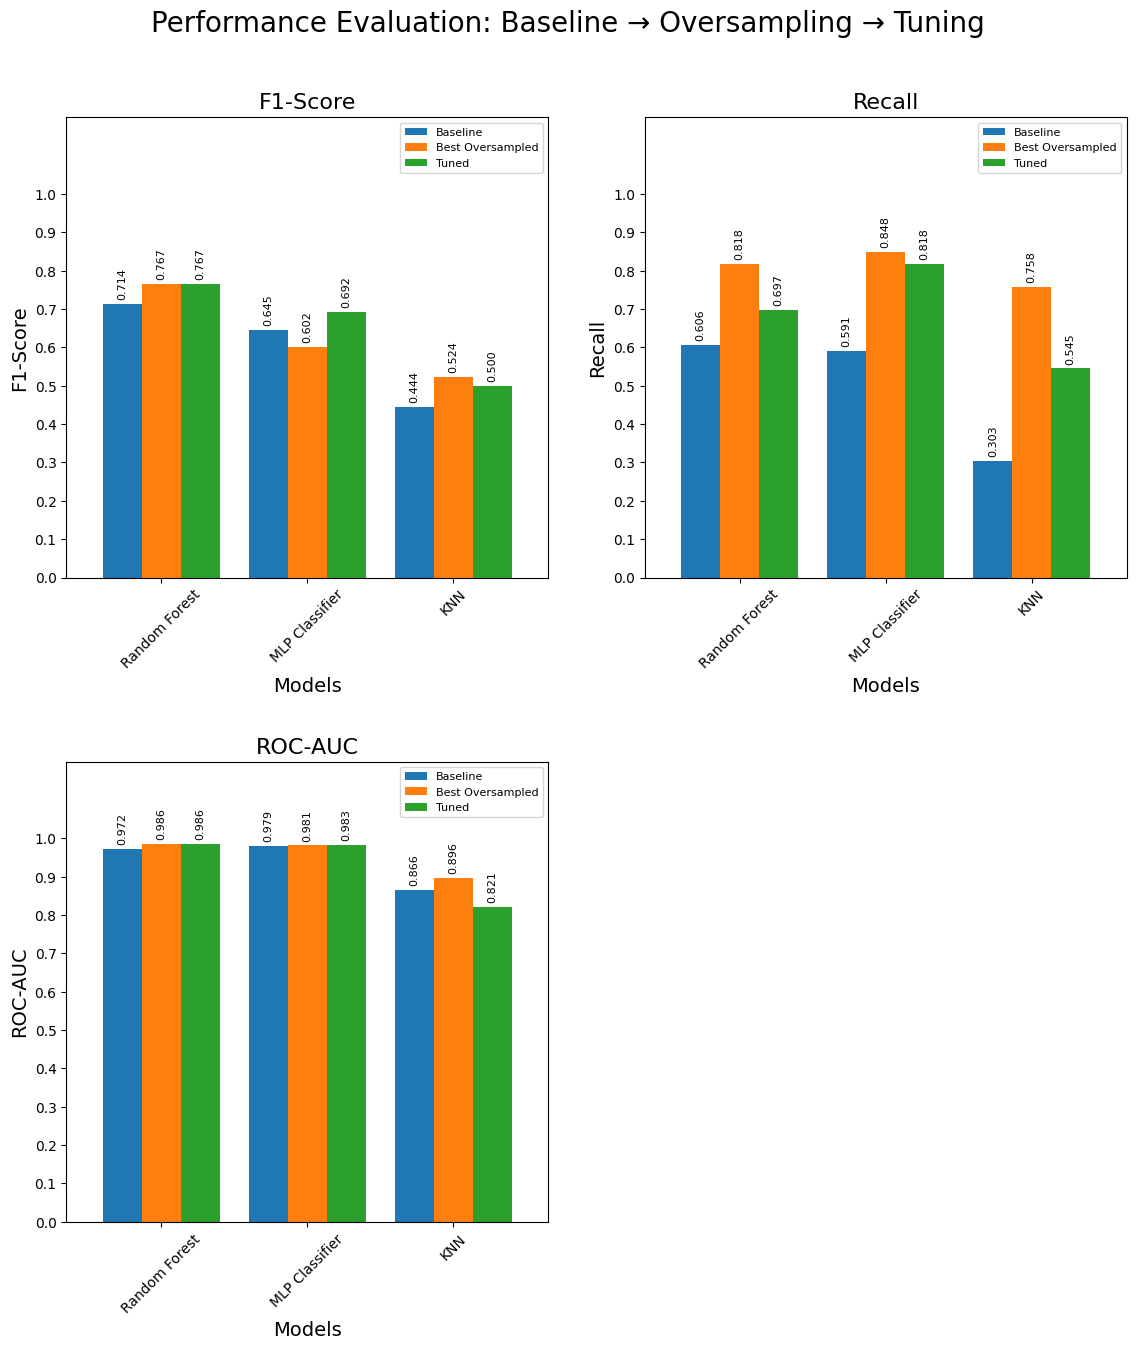

In [54]:
# Stage-wise Performance Comparison (without Loss)

# Create plot
fig, axes = plt.subplots(2, 2, figsize = (12, 14))

# Add main title
fig.suptitle('Performance Evaluation: Baseline → Oversampling → Tuning',
             fontsize = 20, fontweight = 'normal')

# Choose metrics
metrics_to_compare = ['F1-Score', 'Recall', 'ROC-AUC']

# Iterate through each metric
for i, metric in enumerate(metrics_to_compare):
    ax = axes[i // 2, i % 2]

    # Create grouped bar plot by model
    model_groups = []

    # Iterate through each model
    for model in model_names:
        # Filter dataframe
        model_data = all_stage_df[all_stage_df['Model'] == model]

        # Extract baseline performance value
        baseline_val = model_data[model_data['Stage'] == 'Baseline'][metric].values[0]

        # Extract all oversampled performance values
        oversampled_vals = model_data[model_data['Stage'] == 'Oversampled'][metric].values

        # Extract tuned performance value if available, otherwise use 0
        tuned_val = model_data[model_data['Stage'] == 'Tuned'][metric].values[0] if len(model_data[model_data['Stage'] == 'Tuned']) > 0 else 0

        # Append model performance data as a dictionary
        model_groups.append({
            'Model': model,
            'Baseline': baseline_val,
            'Best Oversampled': oversampled_vals.max() if len(oversampled_vals) > 0 else 0,
            'Tuned': tuned_val
        })

    # Create DataFrame
    comparison_df = pd.DataFrame(model_groups)

    # Create grouped bar plot
    bars = comparison_df.set_index('Model').plot(kind = 'bar', ax = ax, width = 0.8)

    # Add subplot title
    ax.set_title(f'{metric}', fontsize = 16, fontweight = 'normal')

    # Set axes labels
    ax.set_xlabel('Models', fontsize = 14, fontweight = 'normal')
    ax.set_ylabel(metric, fontsize = 14, fontweight = 'normal')

    # Add legend
    ax.legend(fontsize = 8)

    # Set ticks
    ax.tick_params(axis = 'x', rotation = 45, labelsize = 10)

    # Grid
    ax.grid(False)

    # Set y-tick and limit
    ax.set_ylim(0, 1.2)
    ax.set_yticks(np.arange(0, 1.1, 0.1))

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt = '%.3f', fontsize = 8, rotation = 90, padding = 3)

# Delete 4th subplot
plt.delaxes(axes[1, 1])

# Adjust layout
plt.tight_layout(pad = 3.0)
plt.subplots_adjust(wspace = 0.2)

# Display the plot
plt.show()

In [55]:
# Final Performance Summary Table

# Create summary for each model
summary_data = []
for model_name in model_names:
    # Baseline
    baseline_metrics = baseline_results[model_name]

    # Best oversampled
    model_oversampled = {k: v for k, v in oversampled_results.items() if v['Model'] == model_name}
    best_oversampled_key = max(model_oversampled.keys(), key = lambda k: model_oversampled[k]['F1-Score'])
    best_oversampled = model_oversampled[best_oversampled_key]

    # Tuned
    tuned_key = [k for k in tuned_results.keys() if tuned_results[k]['Model'] == model_name][0]
    tuned = tuned_results[tuned_key]

    # Create summary table
    summary_data.append({
        'Model': model_name,
        'Baseline F1': baseline_metrics['F1-Score'],
        'Baseline Recall': baseline_metrics['Recall'],
        'Baseline ROC-AUC': baseline_metrics['ROC-AUC'],
        'Best Oversampling': best_oversampled['Oversampling'],
        'Oversampled F1': best_oversampled['F1-Score'],
        'Oversampled Recall': best_oversampled['Recall'],
        'Oversampled ROC-AUC': best_oversampled['ROC-AUC'],
        'Tuned F1': tuned['F1-Score'],
        'Tuned Recall': tuned['Recall'],
        'Tuned ROC-AUC': tuned['ROC-AUC'],
        'F1 Improvement (%)': ((tuned['F1-Score'] - baseline_metrics['F1-Score']) / baseline_metrics['F1-Score'] * 100) if baseline_metrics['F1-Score'] > 0 else 0,
        'Recall Improvement (%)': ((tuned['Recall'] - baseline_metrics['Recall']) / baseline_metrics['Recall'] * 100) if baseline_metrics['Recall'] > 0 else 0,
        'ROC-AUC Improvement (%)': ((tuned['ROC-AUC'] - baseline_metrics['ROC-AUC']) / baseline_metrics['ROC-AUC'] * 100) if baseline_metrics['ROC-AUC'] > 0 else 0
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Display styled summary table
styled_summary = (
    summary_df.style
    .hide(axis = "index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'Baseline F1': '{:.4f}',
        'Baseline Recall': '{:.4f}',
        'Baseline ROC-AUC': '{:.4f}',
        'Oversampled F1': '{:.4f}',
        'Oversampled Recall': '{:.4f}',
        'Oversampled ROC-AUC': '{:.4f}',
        'Tuned F1': '{:.4f}',
        'Tuned Recall': '{:.4f}',
        'Tuned ROC-AUC': '{:.4f}',
        'F1 Improvement (%)': '{:+.2f}%',
        'Recall Improvement (%)': '{:+.2f}%',
        'ROC-AUC Improvement (%)': '{:+.2f}%'
    })
    .set_caption("Complete Performance Evaluation Summary")
)

# Display the table
display(styled_summary)

# Print
print("\nNote: Improvements are calculated as (Tuned - Baseline) / Baseline × 100%")

Model,Baseline F1,Baseline Recall,Baseline ROC-AUC,Best Oversampling,Oversampled F1,Oversampled Recall,Oversampled ROC-AUC,Tuned F1,Tuned Recall,Tuned ROC-AUC,F1 Improvement (%),Recall Improvement (%),ROC-AUC Improvement (%)
Random Forest,0.7143,0.6061,0.9725,RandomOverSampler,0.7667,0.6970,0.9860,0.7667,0.6970,0.9860,+7.33%,+15.00%,+1.39%
MLP Classifier,0.6446,0.5909,0.9793,RandomOverSampler,0.6023,0.8030,0.9815,0.6923,0.8182,0.9828,+7.40%,+38.46%,+0.35%
KNN,0.4444,0.3030,0.8659,RandomOverSampler,0.5238,0.6667,0.8617,0.5000,0.5455,0.8206,+12.50%,+80.00%,-5.23%



Note: Improvements are calculated as (Tuned - Baseline) / Baseline × 100%


In [56]:
# Performance Improvement Validation (with ROC-AUC)

# Create validation summary
validation_data = []

# Iterate through each model to extract baseline performance metrics
for model_name in model_names:
    # Extract F1-Score from baseline results for the current model
    baseline_f1 = baseline_results[model_name]['F1-Score']
    # Extract Recall from baseline results for the current model
    baseline_recall = baseline_results[model_name]['Recall']
    # Extract Roc_AUC from baseline results for the current model
    baseline_roc = baseline_results[model_name]['ROC-AUC']

    # Find best tuned result
    tuned_key = [k for k in tuned_results.keys() if model_name in k][0]
    tuned_f1 = tuned_results[tuned_key]['F1-Score']
    tuned_recall = tuned_results[tuned_key]['Recall']
    tuned_roc = tuned_results[tuned_key]['ROC-AUC']

    # Calculate improvements - handle all cases including negative improvements
    if baseline_f1 > 0:
        f1_improvement = ((tuned_f1 - baseline_f1) / baseline_f1) * 100
    else:
        f1_improvement = 100 if tuned_f1 > 0 else 0

    if baseline_recall > 0:
        recall_improvement = ((tuned_recall - baseline_recall) / baseline_recall) * 100
    else:
        recall_improvement = 100 if tuned_recall > 0 else 0

    if baseline_roc > 0:
        roc_improvement = ((tuned_roc - baseline_roc) / baseline_roc) * 100
    else:
        roc_improvement = 100 if tuned_roc > 0 else 0

    # Determine meaningful improvement based on F1-score improvement
    meaningful = '✓' if f1_improvement > 5 else '✗'

    # Create summary table
    validation_data.append({
        'Model': model_name,
        'Baseline_F1': baseline_f1,
        'Tuned_F1': tuned_f1,
        'F1_Change': f'{f1_improvement:+.1f}%',
        'Baseline_Recall': baseline_recall,
        'Tuned_Recall': tuned_recall,
        'Recall_Change': f'{recall_improvement:+.1f}%',
        'Baseline_ROC_AUC': baseline_roc,
        'Tuned_ROC_AUC': tuned_roc,
        'ROC_AUC_Change': f'{roc_improvement:+.1f}%',
        'Meaningful_Improvement': meaningful
    })

# Create DataFrame
validation_df = pd.DataFrame(validation_data)

# Style the table
styled_validation_table = (
    validation_df.style
    .hide(axis = "index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'Baseline_F1': '{:.4f}',
        'Tuned_F1': '{:.4f}',
        'Baseline_Recall': '{:.4f}',
        'Tuned_Recall': '{:.4f}',
        'Baseline_ROC_AUC': '{:.4f}',
        'Tuned_ROC_AUC': '{:.4f}'
    })
    .set_caption("Performance Improvement Validation")
)

# Display the plot
display(styled_validation_table)

# Print
print("\nNote: Improvements are calculated as (Tuned - Baseline) / Baseline × 100%")

Model,Baseline_F1,Tuned_F1,F1_Change,Baseline_Recall,Tuned_Recall,Recall_Change,Baseline_ROC_AUC,Tuned_ROC_AUC,ROC_AUC_Change,Meaningful_Improvement
Random Forest,0.7143,0.7667,+7.3%,0.6061,0.6970,+15.0%,0.9725,0.9860,+1.4%,✓
MLP Classifier,0.6446,0.6923,+7.4%,0.5909,0.8182,+38.5%,0.9793,0.9828,+0.4%,✓
KNN,0.4444,0.5000,+12.5%,0.3030,0.5455,+80.0%,0.8659,0.8206,-5.2%,✓



Note: Improvements are calculated as (Tuned - Baseline) / Baseline × 100%


In [57]:
# Statistical Significance Testing
print("\n" + "-"*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("-"*80)

# Perform McNemar's test for each model comparing baseline vs best configuration
for model_name in model_names:
    print(f"\n{model_name}:")

    # Get predictions
    baseline_pred = baseline_predictions[model_name]

    # Find best configuration (tuned)
    tuned_key = [k for k in tuned_predictions.keys() if model_name in k][0]
    tuned_pred = tuned_predictions[tuned_key]

    # Create contingency table
    correct_baseline = (baseline_pred == y_test)
    correct_tuned = (tuned_pred == y_test)

    # McNemar's test contingency table
    n00 = np.sum((~correct_baseline) & (~correct_tuned))
    n01 = np.sum((~correct_baseline) & correct_tuned)
    n10 = np.sum(correct_baseline & (~correct_tuned))
    n11 = np.sum(correct_baseline & correct_tuned)

    # Create contigency table
    contingency_table = np.array([[n11, n10], [n01, n00]])

    # Perform McNemar's test
    result = mcnemar(contingency_table, exact = False, correction = True)

    # Print
    print(f"  Contingency Table:")
    print(f"    Both Correct: {n11}")
    print(f"    Baseline Only Correct: {n10}")
    print(f"    Tuned Only Correct: {n01}")
    print(f"    Both Wrong: {n00}")
    print(f"  McNemar's Test Statistic: {result.statistic:.4f}")
    print(f"  p-value: {result.pvalue:.4f}")

    # Check if the p-value from the statistical test indicates significant results
    if result.pvalue < 0.05:
        print(f"  Result: Significant improvement (p < 0.05)")
    else:
        print(f"  Result: No significant difference (p >= 0.05)")


--------------------------------------------------------------------------------
STATISTICAL SIGNIFICANCE TESTING
--------------------------------------------------------------------------------

Random Forest:
  Contingency Table:
    Both Correct: 1955
    Baseline Only Correct: 8
    Tuned Only Correct: 12
    Both Wrong: 20
  McNemar's Test Statistic: 0.4500
  p-value: 0.5023
  Result: No significant difference (p >= 0.05)

MLP Classifier:
  Contingency Table:
    Both Correct: 1927
    Baseline Only Correct: 25
    Tuned Only Correct: 20
    Both Wrong: 23
  McNemar's Test Statistic: 0.3556
  p-value: 0.5510
  Result: No significant difference (p >= 0.05)

KNN:
  Contingency Table:
    Both Correct: 1907
    Baseline Only Correct: 38
    Tuned Only Correct: 16
    Both Wrong: 34
  McNemar's Test Statistic: 8.1667
  p-value: 0.0043
  Result: Significant improvement (p < 0.05)


##Overfitting/Underfitting Analysis

In [58]:
# Print
print("\n" + "-"*80)
print("OVERFITTING/UNDERFITTING ANALYSIS FOR TOP PERFORMERS")
print("-"*80)

# Identify 3 best performing model+oversampling combinations
all_combinations = []
for key, result in oversampled_results.items():
    all_combinations.append({
        'Combination': key,
        'Model': result['Model'],
        'Technique': result['Oversampling'],
        'F1-Score': result['F1-Score']
    })

# Sort and get top 3
sorted_combinations = sorted(all_combinations, key = lambda x: x['F1-Score'], reverse = True)

# Ensure KNN + RandomOverSampler is included
knn_ros = next((x for x in sorted_combinations if x['Model'] == 'KNN' and x['Technique'] == 'RandomOverSampler'), None)
if knn_ros:
    # If KNN+ROS is not in top 3, replace the 3rd one
    if knn_ros not in sorted_combinations[:3]:
        top_3_combinations = sorted_combinations[:2] + [knn_ros]
    else:
        top_3_combinations = sorted_combinations[:3]
else:
    top_3_combinations = sorted_combinations[:3]

print("\nTop 3 Performing Combinations:")
for i, combo in enumerate(top_3_combinations):
    print(f"{i+1}. {combo['Model']} + {combo['Technique']} (F1: {combo['F1-Score']:.4f})")

# Analyze overfitting/underfitting for top 3
overfitting_analysis = []

# Iterate through the top 3 best performing model-technique combinations
for combo in top_3_combinations:
    model_name = combo['Model']
    technique = combo['Technique']

    # Get appropriate model and data
    if model_name == 'Random Forest':
        X_use = resampled_datasets[technique]['unscaled'][0]
        model = RandomForestClassifier(random_state=17)
    else:
        X_use = resampled_datasets[technique]['scaled'][0]
        if model_name == 'KNN':
            model = KNeighborsClassifier()
        else:
            model = MLPClassifier(hidden_layer_sizes = (128, 64, 32),
                                max_iter = 200, random_state = 17)

    # Extract the target variable (y) from the resampled dataset for a specific technique
    y_use = resampled_datasets[technique]['scaled'][1]

    # Generate learning curve for final analysis
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_use, y_use, train_sizes = [0.3, 0.5, 0.7, 0.9, 1.0],
        cv = 3, scoring = 'f1', n_jobs = -1, random_state = 17
    )

    # Calculate final training score/final validation score/generalization gap by averaging the last epoch's training scores
    final_train = np.mean(train_scores[-1])
    final_val = np.mean(val_scores[-1])
    gap = final_train - final_val

    # Determine status
    if gap > 0.05:
        if final_val < 0.7:
            status = "OVERFITTING - High bias, high variance"
            recommendation = "Reduce complexity, add regularization"
        else:
            status = "MILD OVERFITTING - Acceptable"
            recommendation = "Consider slight regularization"
    elif gap < -0.02:
        status = "GOOD GENERALIZATION"
        recommendation = "Model is performing optimally"
    elif final_val < 0.6:
        status = "UNDERFITTING - High bias"
        recommendation = "Increase model complexity"
    else:
        status = "WELL-FITTED"
        recommendation = "Model is well-tuned"

    # Append overfitting analysis
    overfitting_analysis.append({
        'Model_Technique': f"{model_name} + {technique}",
        'Training_Score': final_train,
        'Validation_Score': final_val,
        'Gap': gap,
        'Status': status,
        'Recommendation': recommendation
    })

# Display overfitting analysis table
overfitting_df = pd.DataFrame(overfitting_analysis)

# Style table
styled_overfitting_table = (
    overfitting_df.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th, td', 'props': 'border: 1px solid black;'},
        {'selector': 'th', 'props': 'background-color: lightgray;'}
    ])
    .format({
        'Training_Score': '{:.4f}',
        'Validation_Score': '{:.4f}',
        'Gap': '{:.4f}'
    })
    .set_caption("Overfitting/Underfitting Analysis for Top Performers")
)

# Display the table
display(styled_overfitting_table)


--------------------------------------------------------------------------------
OVERFITTING/UNDERFITTING ANALYSIS FOR TOP PERFORMERS
--------------------------------------------------------------------------------

Top 3 Performing Combinations:
1. Random Forest + RandomOverSampler (F1: 0.7667)
2. MLP Classifier + RandomOverSampler (F1: 0.6023)
3. KNN + RandomOverSampler (F1: 0.5238)


Model_Technique,Training_Score,Validation_Score,Gap,Status,Recommendation
Random Forest + RandomOverSampler,1.0000,0.9958,0.0042,WELL-FITTED,Model is well-tuned
MLP Classifier + RandomOverSampler,0.9973,0.9906,0.0067,WELL-FITTED,Model is well-tuned
KNN + RandomOverSampler,0.9850,0.9789,0.0061,WELL-FITTED,Model is well-tuned


## Research Findings and Conclusions

In [59]:
# Find absolute best model + oversampling combination
best_overall = max([(k, v) for k, v in oversampled_results.items()],
                   key = lambda x: x[1]['F1-Score'])
best_model = best_overall[1]['Model']
best_technique = best_overall[1]['Oversampling']
best_f1_score = best_overall[1]['F1-Score']

# Print
print(f"\n★ BEST OVERALL COMBINATION: {best_model} + {best_technique}")
print(f"   Achieves F1-Score: {best_f1_score:.4f}")

# Calculate average improvements
avg_improvements = []
for model_name in model_names:
    baseline_f1 = baseline_results[model_name]['F1-Score']
    baseline_recall = baseline_results[model_name]['Recall']
    baseline_roc = baseline_results[model_name]['ROC-AUC']

    # Get best oversampled results
    model_oversampled = {k: v for k, v in oversampled_results.items() if v['Model'] == model_name}
    best_oversampled = max(model_oversampled.items(), key = lambda x: x[1]['F1-Score'])
    best_technique_model = best_oversampled[1]['Oversampling']
    best_f1 = best_oversampled[1]['F1-Score']
    best_recall = max([v['Recall'] for v in model_oversampled.values()])
    best_roc = max([v['ROC-AUC'] for v in model_oversampled.values()])

    # Calculate improvements
    f1_imp = ((best_f1 - baseline_f1) / baseline_f1 * 100) if baseline_f1 > 0 else 0
    recall_imp = ((best_recall - baseline_recall) / baseline_recall * 100) if baseline_recall > 0 else 0
    roc_imp = ((best_roc - baseline_roc) / baseline_roc * 100) if baseline_roc > 0 else 0

    # Append improvement analysis
    avg_improvements.append({
        'Model': model_name,
        'Best_Technique': best_technique_model,
        'F1 Improvement': f1_imp,
        'Recall Improvement': recall_imp,
        'ROC-AUC Improvement': roc_imp
    })

# Create DataFrame
improvements_df = pd.DataFrame(avg_improvements)

# Print
print("\nKEY FINDINGS:")
print("\n1. F1-Score Improvements:")
for _, row in improvements_df.iterrows():
    improvement = row['F1 Improvement']
    print(f"   {row['Model']} + {row['Best_Technique']}: {improvement:+.2f}%")

print("\n2. Recall Improvements (Critical for Failure Detection):")
for _, row in improvements_df.iterrows():
    improvement = row['Recall Improvement']
    print(f"   {row['Model']} + {row['Best_Technique']}: {improvement:+.2f}%")

print("\n3. ROC-AUC Improvements:")
# Iterate through each row in the improvements DataFrame
for _, row in improvements_df.iterrows():
    improvement = row['ROC-AUC Improvement']
    print(f"   {row['Model']} + {row['Best_Technique']}: {improvement:+.2f}%")

# Best techniques analysis
print("\n4. Most Effective Oversampling Techniques:")
# Initialize an empty dictionary
technique_effectiveness = {}

# Iterate through all oversampled results to aggregate performance by technique
for key, result in oversampled_results.items():
    technique = result['Oversampling']
    if technique not in technique_effectiveness:
        technique_effectiveness[technique] = []
    technique_effectiveness[technique].append(result['F1-Score'])

# Iterate through each oversampling technique and its corresponding performance scores
for technique, scores in technique_effectiveness.items():
    avg_score = np.mean(scores)
    print(f"   {technique}: Average F1-Score = {avg_score:.4f}")

print("\n5. Model-Specific Recommendations:")
# Iterate through each model to find the optimal oversampling technique/F1 score
for model_name in model_names:
    model_results = results_df[results_df['Model'] == model_name]
    best_technique = model_results.loc[model_results['F1-Score'].idxmax(), 'Oversampling']
    best_f1 = model_results['F1-Score'].max()
    print(f"   {model_name}: Use {best_technique} (F1-Score: {best_f1:.4f})")

# Final recommendations
print("\n" + "-"*80)
print("FINAL RECOMMENDATIONS FOR IMPLEMENTATION")
print("-"*80)

print("\n1. For Maximum Recall (Catching Most Failures):")
# Find the best performing model-technique combination based on Recall metric
best_recall_combo = max([(k, v) for k, v in oversampled_results.items()],
                       key = lambda x: x[1]['Recall'])
print(f"   Use {best_recall_combo[1]['Model']} + {best_recall_combo[1]['Oversampling']}")
print(f"   Achieves {best_recall_combo[1]['Recall']:.2%} recall")

print("\n2. For Balanced Performance (F1-Score):")
# Find the best performing model-technique combination based on F1-Score metric
best_f1_combo = max([(k, v) for k, v in oversampled_results.items()],
                    key = lambda x: x[1]['F1-Score'])
print(f"   Use {best_f1_combo[1]['Model']} + {best_f1_combo[1]['Oversampling']}")
print(f"   Achieves {best_f1_combo[1]['F1-Score']:.4f} F1-Score")


★ BEST OVERALL COMBINATION: Random Forest + RandomOverSampler
   Achieves F1-Score: 0.7667

KEY FINDINGS:

1. F1-Score Improvements:
   Random Forest + RandomOverSampler: +7.33%
   MLP Classifier + RandomOverSampler: -6.57%
   KNN + RandomOverSampler: +17.86%

2. Recall Improvements (Critical for Failure Detection):
   Random Forest + RandomOverSampler: +35.00%
   MLP Classifier + RandomOverSampler: +43.59%
   KNN + RandomOverSampler: +150.00%

3. ROC-AUC Improvements:
   Random Forest + RandomOverSampler: +1.39%
   MLP Classifier + RandomOverSampler: +0.22%
   KNN + RandomOverSampler: +3.50%

4. Most Effective Oversampling Techniques:
   SMOTE: Average F1-Score = 0.5459
   ADASYN: Average F1-Score = 0.5393
   RandomOverSampler: Average F1-Score = 0.6309
   SMOTETomek: Average F1-Score = 0.5380

5. Model-Specific Recommendations:
   Random Forest: Use RandomOverSampler (F1-Score: 0.7667)
   MLP Classifier: Use RandomOverSampler (F1-Score: 0.6023)
   KNN: Use RandomOverSampler (F1-Scor